In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch import optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from collections import OrderedDict

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders, load_mnistc
from lateral_connections.layers import LaterallyConnectedLayer
from lateral_connections.torch_utils import *

import wandb
import datetime

DO_WANDB = True

In [3]:
config = {
    'num_classes': 10,
    'learning_rate': 3e-3,
    'num_multiplex': 3,
    'batch_size': 10,
    'num_epochs': 20,
    'lcl_alpha': 3e-3,
    'lcl_eta': 0.05,
    'lcl_theta': 0.2,
    'lcl_iota': 0.2,
    'lcl_distance': 2,
    'conv_size': 8,
    'num_noisy_iterations': 500
}

In [4]:
base_name = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
wandb_run_name = base_name
wandb_group_name = 'TinyLCL_Debug'

wandb.login(key='efd0a05b7bd26ed445bf073625a373b845fc9385')
wandb.init(
    project='MT_LateralConnections',
    entity='lehl',
    #group=wandb_group_name,
    group='debug',
    name=wandb_run_name,
    config=config,
    mode='disabled'
)

wandb: Currently logged in as: lehl (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/claude/.netrc


In [5]:
def plot_kernels(model, plot_scale=3):
    num_kernels = model.lcl.K.shape[0]

    fig, axs = plt.subplots(num_kernels, num_kernels, figsize=(plot_scale*num_kernels, plot_scale*num_kernels))

    kernel_data = model.lcl.K.cpu()

    for x in range(num_kernels):
        for y in range(num_kernels):
            axs[x,y].imshow(kernel_data[x,y,...])
            
    plt.show()
    plt.close()

class TinyLateralNetwork(nn.Module):
    def __init__(self, config):
        super(TinyLateralNetwork, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.config = config
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=config['conv_size'], padding=1, kernel_size=(3,3))
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=config['conv_size'], out_channels=config['conv_size'], padding=1, kernel_size=(3,3))
        self.relu2 = nn.ReLU()
        self.maxpool = nn.AdaptiveMaxPool2d((14, 14))
        self.lcl = LaterallyConnectedLayer(self.config['num_multiplex'], config['conv_size'], 14, 14,
                              d=self.config['lcl_distance'],
                              prd=self.config['lcl_distance'],
                              disabled=False,
                              alpha=self.config['lcl_alpha'],
                              eta=self.config['lcl_eta'],
                              theta=self.config['lcl_theta'],
                              iota=self.config['lcl_iota'],
                              use_scaling=False,
                              random_k_change=False,
                              random_multiplex_selection=False,
                              gradient_learn_k=False,
                              num_noisy_iterations=config['num_noisy_iterations'])
        
        self.fc1 = nn.Linear(in_features=config['conv_size']*14*14, out_features=100)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=100, out_features=self.config['num_classes'])
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=self.config['learning_rate'], momentum=0.9, weight_decay=0.0005)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x = self.lcl(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x
    
    def train_with_loader(self, train_loader, val_loader, test_loader=None, num_epochs=5):
        total_params = sum(p.numel() for p in self.parameters())
        print(f"[INFO]: {total_params:,} total parameters.")
        total_trainable_params = sum(
            p.numel() for p in self.parameters() if p.requires_grad)
        print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

        for epoch in range(num_epochs):
            print(f"[INFO]: Epoch {epoch} of {num_epochs}")
            self.train()

            correct = 0
            total = 0
            total_loss = 0
            counter = 0

            agg_correct = 0
            agg_total = 0
            agg_loss = 0

            # Training Loop
            for i, (images, labels) in tqdm(enumerate(train_loader, 0), total=len(train_loader), desc='Training'):
                counter += 1
                
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self(images)
                loss = self.loss_fn(outputs, labels)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                _, preds = torch.max(outputs, 1)
        
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                total_loss += (loss.item() / labels.size(0))

                current_iteration = epoch*len(train_loader) + i

                if current_iteration > 0 and (current_iteration % 1250) == 0:
                    #self.save(f"models/vgg_with_lcl/{self.run_identifier}__it{current_iteration}_e{epoch}.pt")
                    val_acc, val_loss = self.test(val_loader)
                    log_dict = { 'val_loss': val_loss, 'val_acc': val_acc, 'iteration': current_iteration }

                    if test_loader:
                        test_acc, test_loss = self.test(test_loader)
                        log_dict['test_acc'] = test_acc
                        log_dict['test_loss'] = test_loss

                    wandb.log(log_dict, commit=False)

                if (current_iteration % 250) == 0:
                    wandb.log({ 'train_batch_loss': round(total_loss/250,4), 'train_batch_acc': round(correct/total,4), 'iteration': current_iteration })
                    
                    agg_correct += correct
                    agg_total += total
                    agg_loss += total_loss

                    correct = 0
                    total = 0
                    total_loss = 0
                    counter = 0
                
            plot_kernels(self)
            wandb.log({'epoch': epoch, 'iteration': current_iteration, 'train_loss': agg_loss/len(train_loader), 'train_acc': agg_correct/agg_total})

    def test(self, test_loader):
        self.eval()

        correct = 0
        total = 0
        total_loss = 0
        counter = 0

        # Evaluation Loop
        for i, (images, labels) in tqdm(enumerate(test_loader, 0), total=len(test_loader), desc='Testing', leave=False):
            counter += 1
            images = images.to(self.device)
            labels = labels.to(self.device)

            outputs = self(images)
            loss = self.loss_fn(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
    
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += (loss.item() / labels.size(0))

        total_loss /= counter
        acc = correct / total

        return acc, total_loss

In [6]:
model = TinyLateralNetwork(config)
model.to(model.device)

TinyLateralNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool): AdaptiveMaxPool2d(output_size=(14, 14))
  (lcl): LaterallyConnectedLayer(3, (8, 14, 14), d=2, disabled=False, update=True)
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [7]:
def small_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
    ])

dataset = MNIST('images/mnist/', train=True, transform=small_transform(), download=True)

train_size = 50000
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=1)

corrupt_dataset = load_mnistc('line')

corrupt_loader = torch.utils.data.DataLoader(corrupt_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=1)

In [32]:
model.train_with_loader(train_loader, val_loader, num_epochs=config['num_epochs'])

[INFO]: 208,194 total parameters.
[INFO]: 198,120 trainable parameters.
[INFO]: Epoch 0 of 20


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

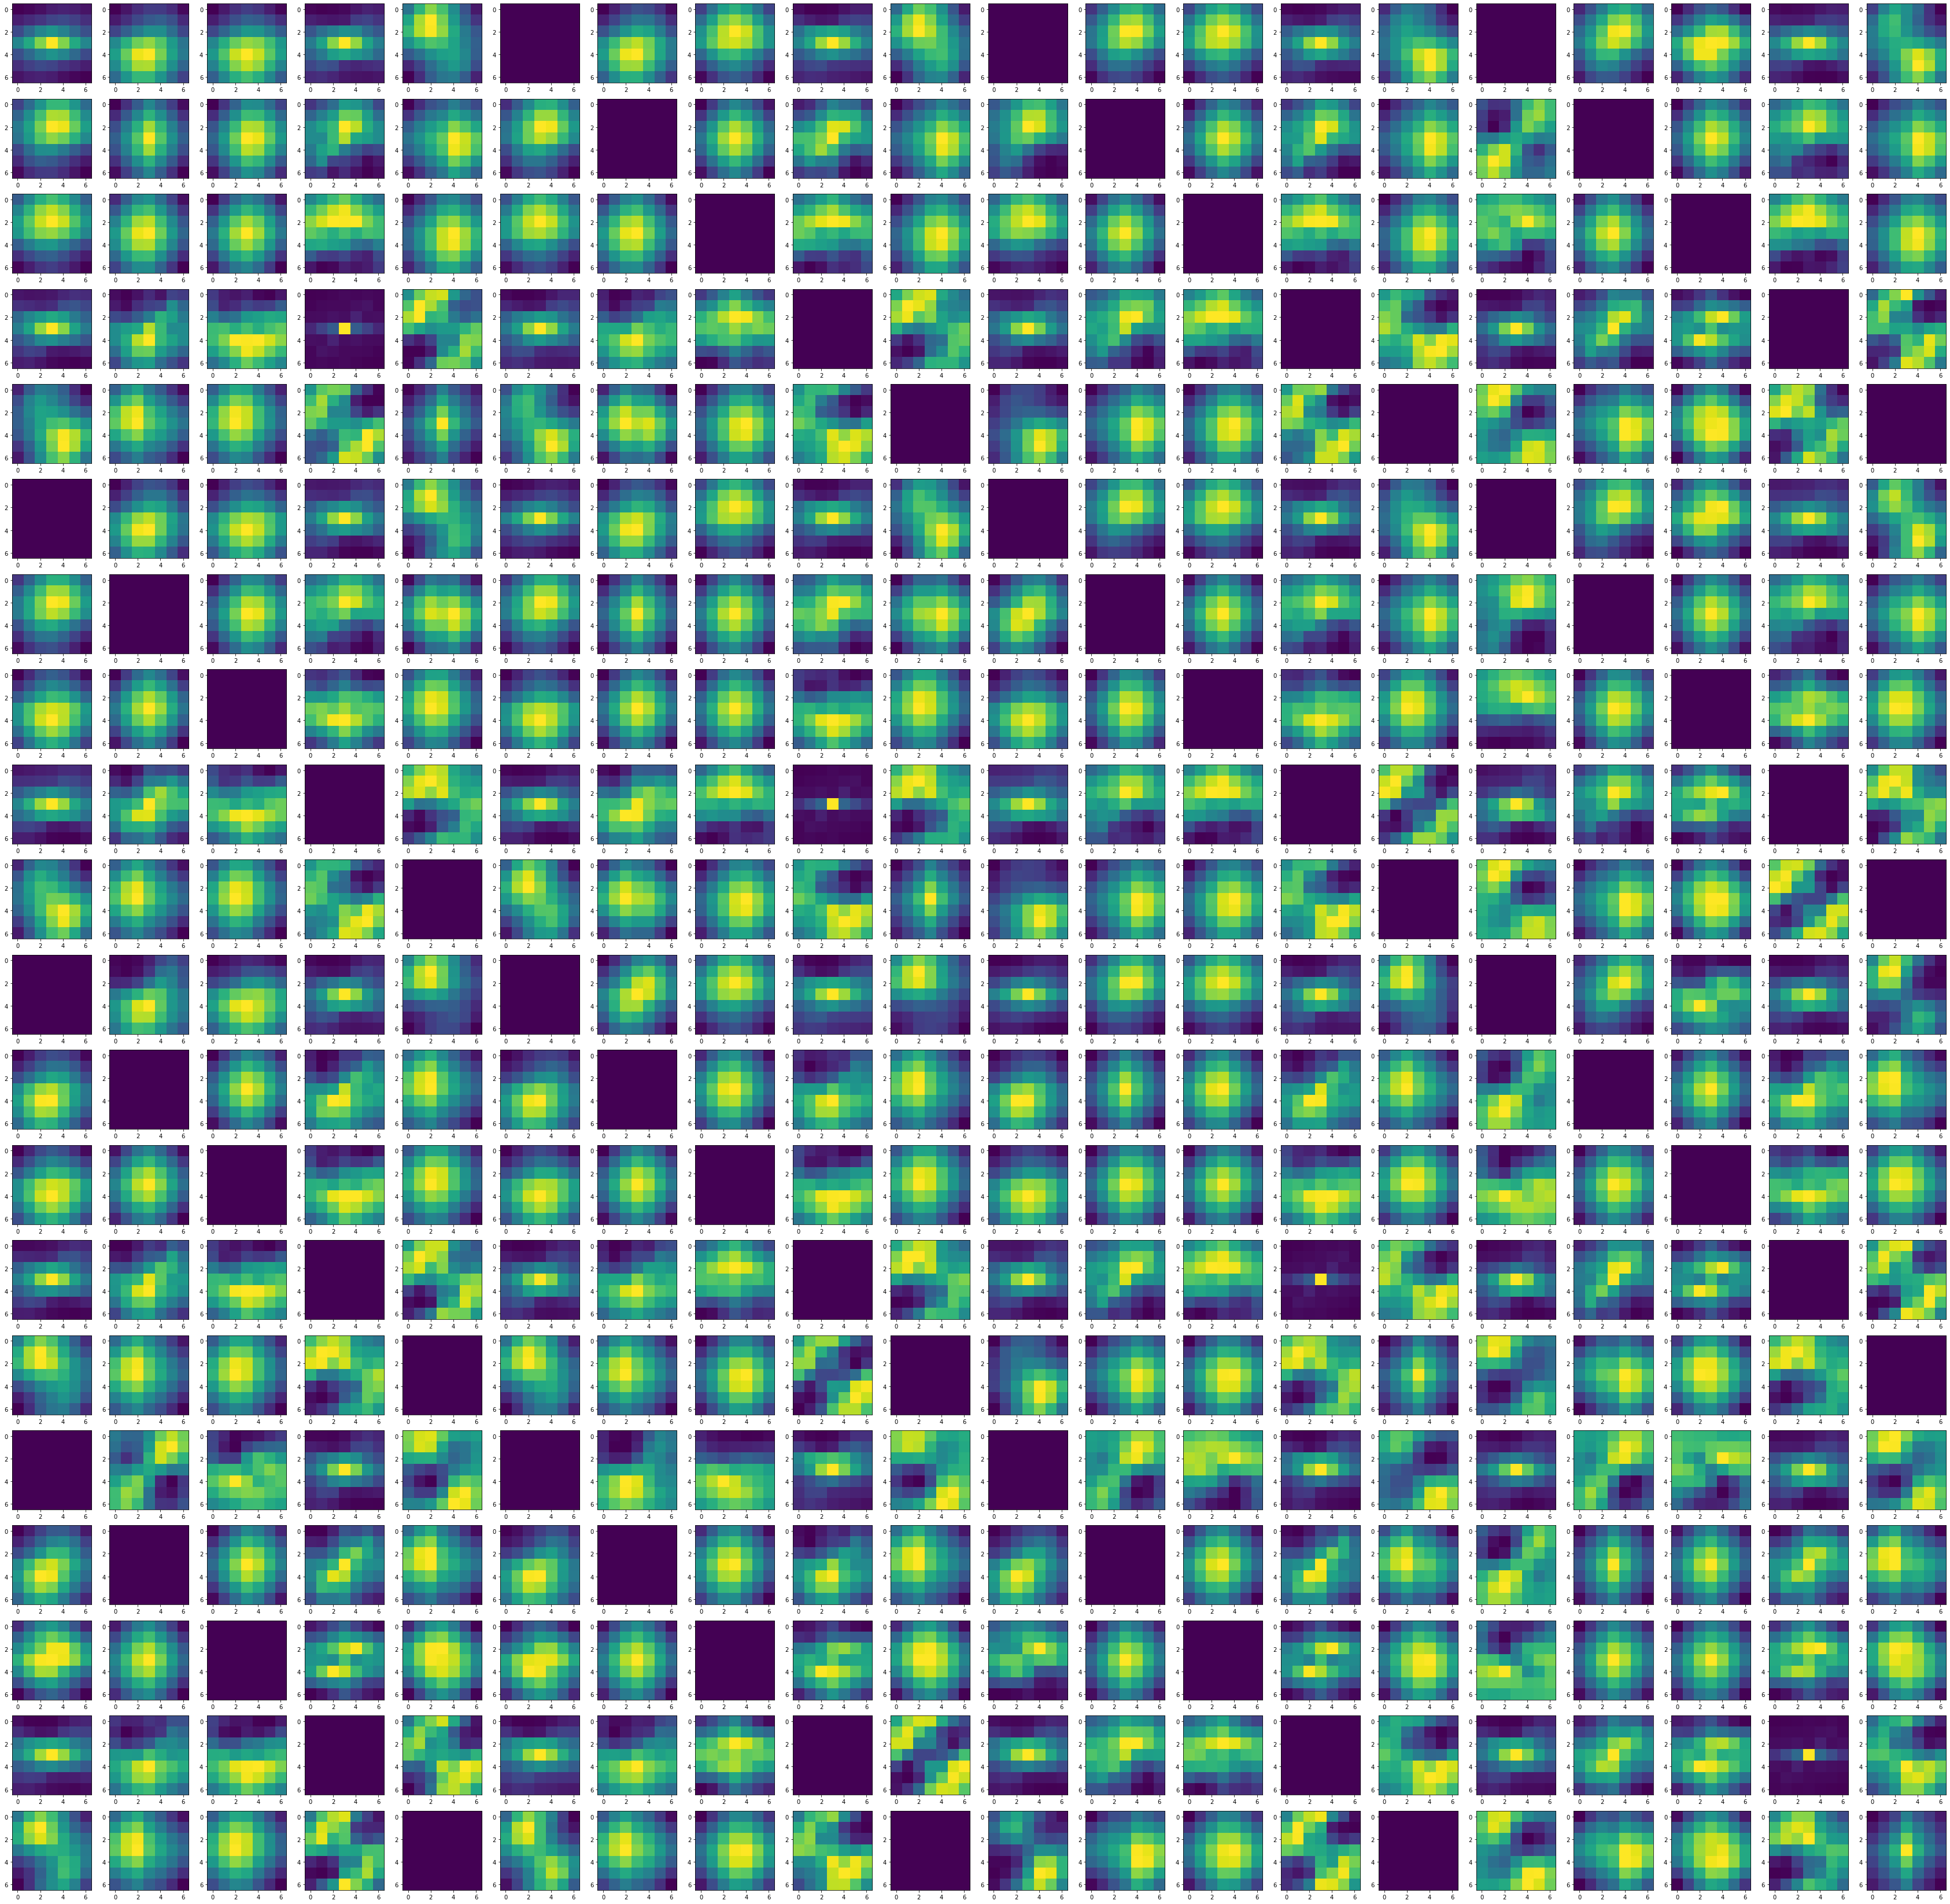

In [9]:
# After 1 Epoch on MNIST (with Noise)
#model.train_with_loader(train_loader, val_loader, num_epochs=1)
plot_kernels(model)

Error in callback <function _WandbInit._resume_backend at 0x7f152a3e9940> (for pre_run_cell):


Exception: The wandb backend process has shutdown

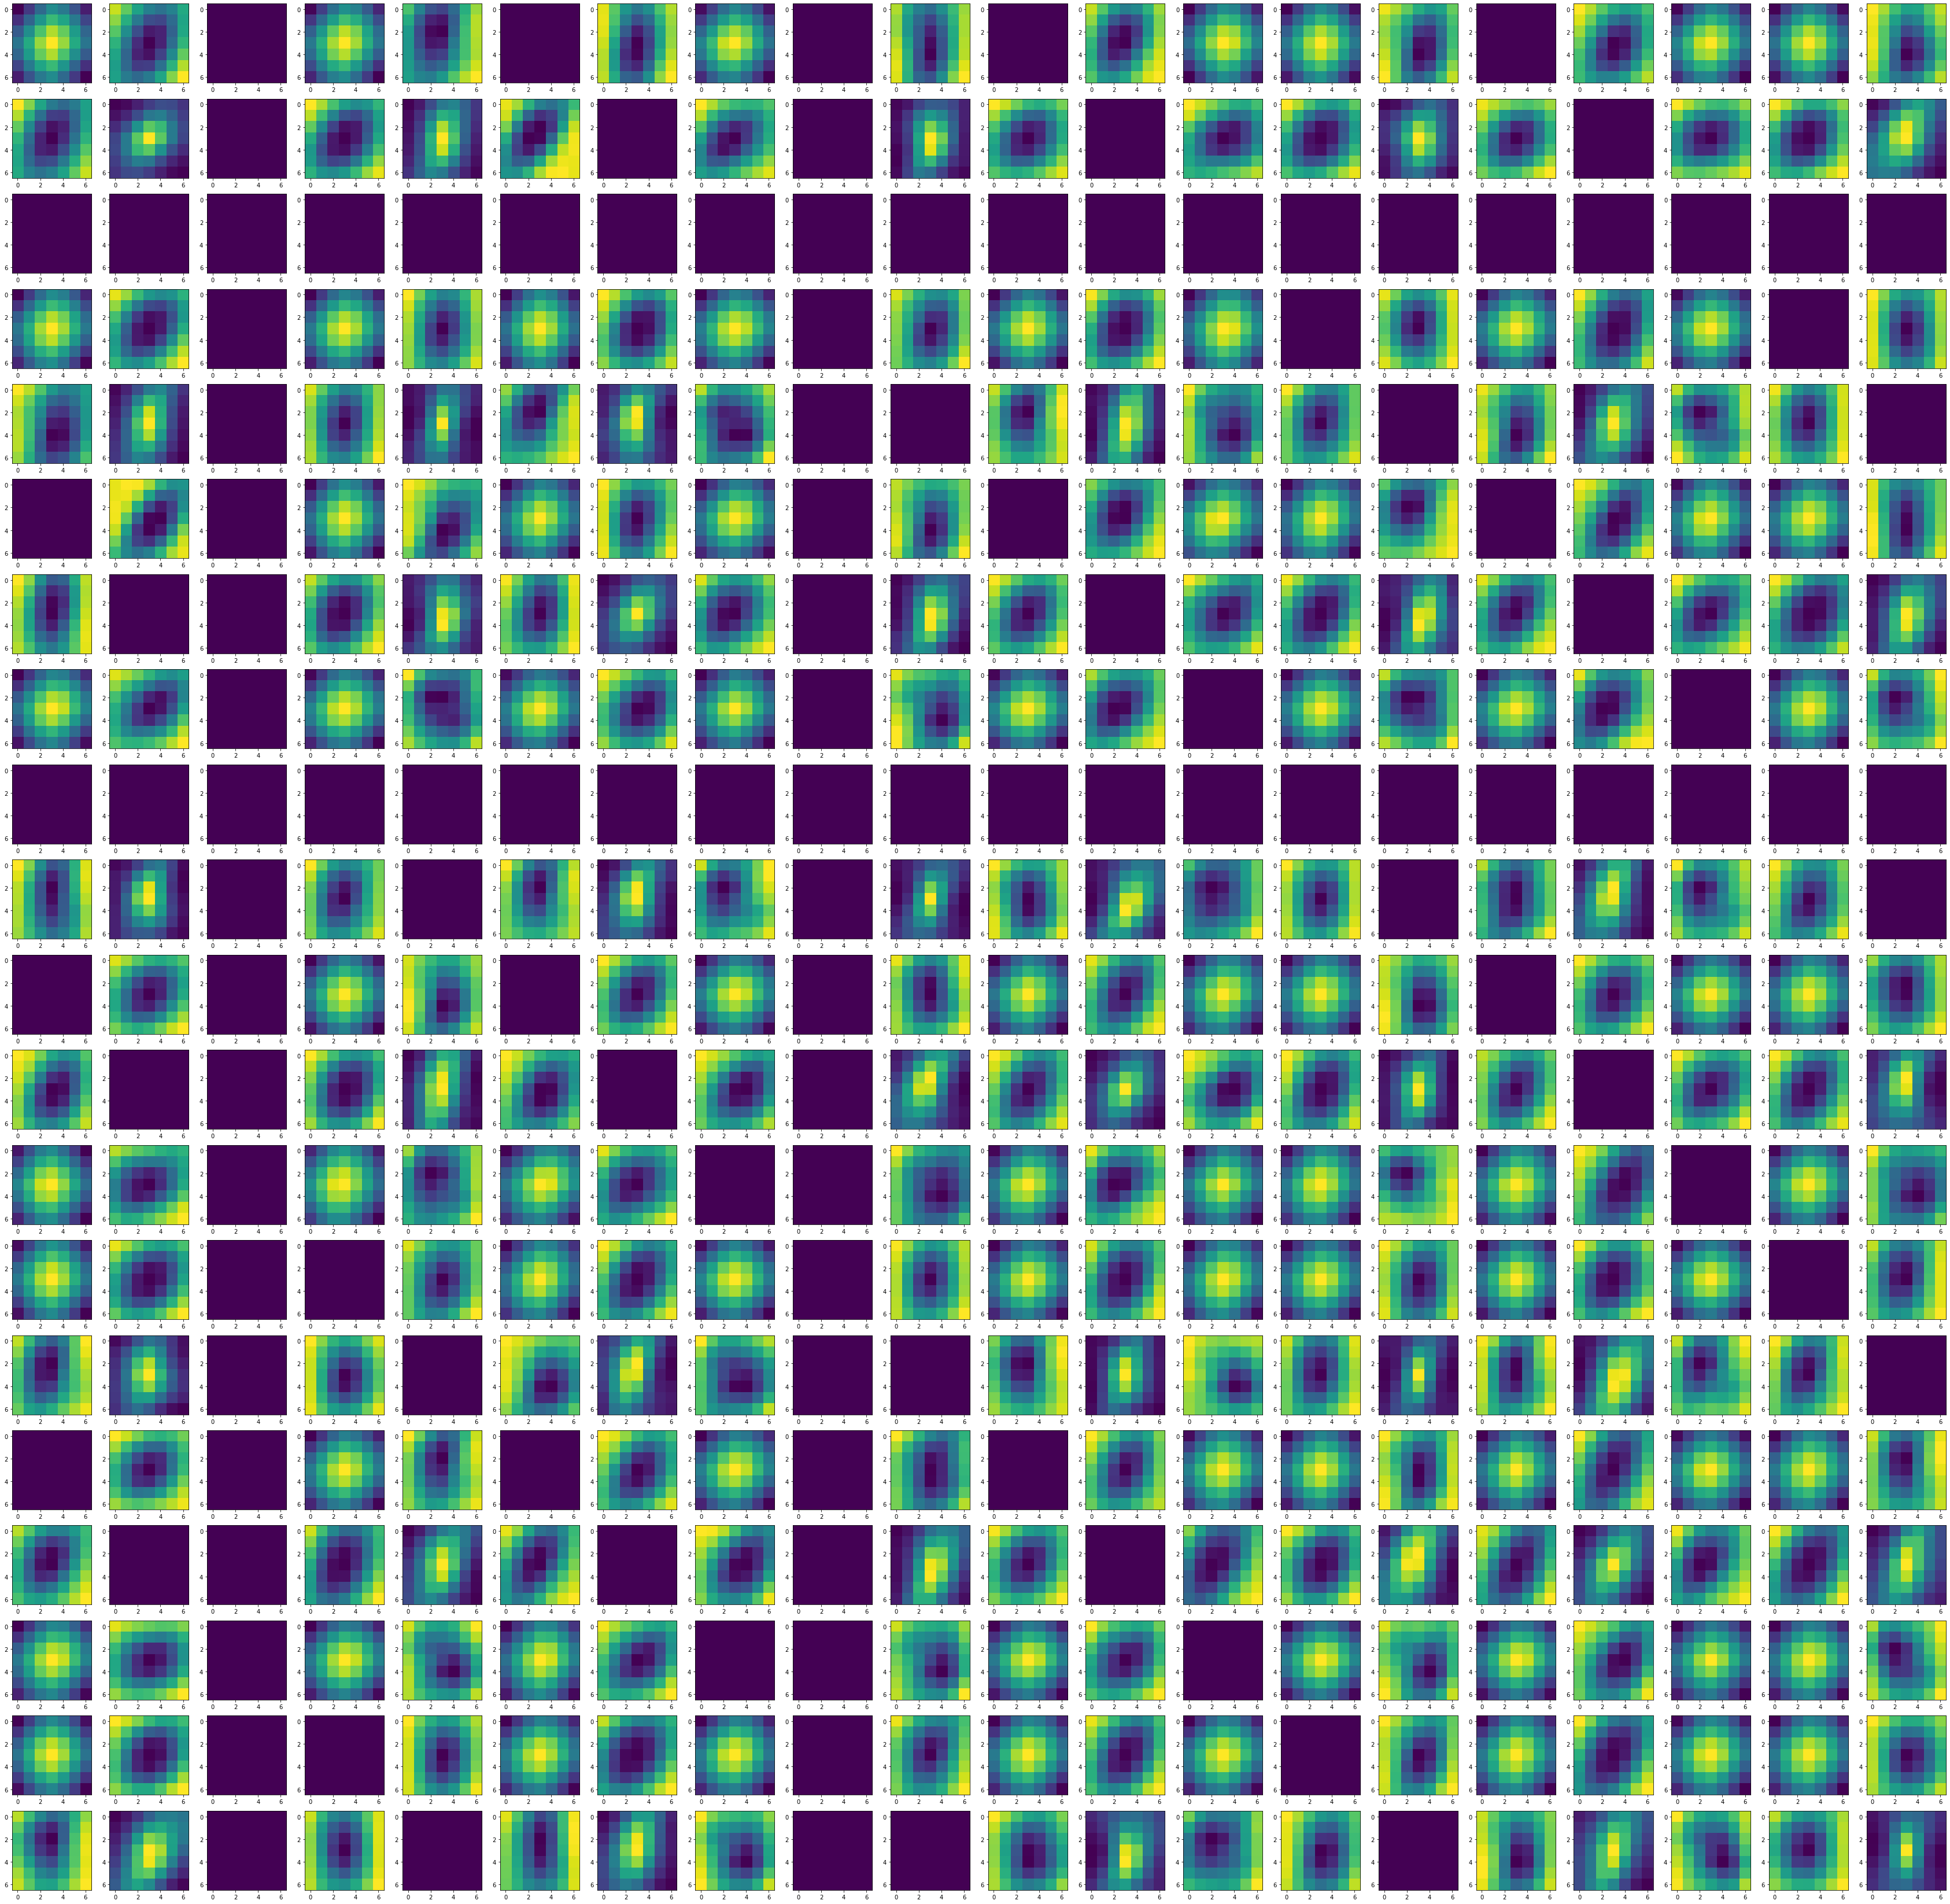

Error in callback <function _WandbInit._pause_backend at 0x7f152a3e90d0> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [12]:
# After 2 Epochs on MNIST (1k with, 1k without noise)
model.train_with_loader(train_loader, val_loader, num_epochs=1)
plot_kernels(model)

In [14]:
wandb.finish()

AttributeError: 'ZMQDisplayPublisher' object has no attribute '_orig_publish'

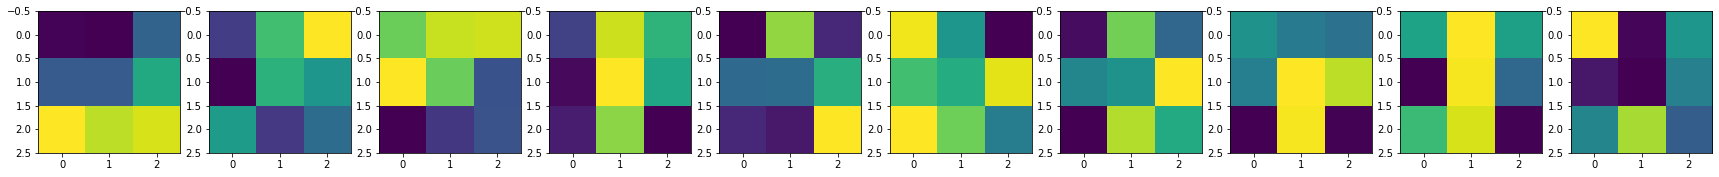

In [33]:
s1, _, _, _ = model.conv1.weight.shape
plot_scale = 3

fig, axs = plt.subplots(1, s1, figsize=(s1*plot_scale, 1*plot_scale))

for x in range(s1):
    axs[x].imshow(model.conv1.weight.cpu().detach().numpy()[x, 0, ...])

In [12]:
torch.sum(model.conv1.weight, dim=(-2,-1))

tensor([[ 3.1965],
        [-0.0542],
        [-3.9443],
        [-0.0166],
        [-3.1831]], device='cuda:0', grad_fn=<SumBackward1>)

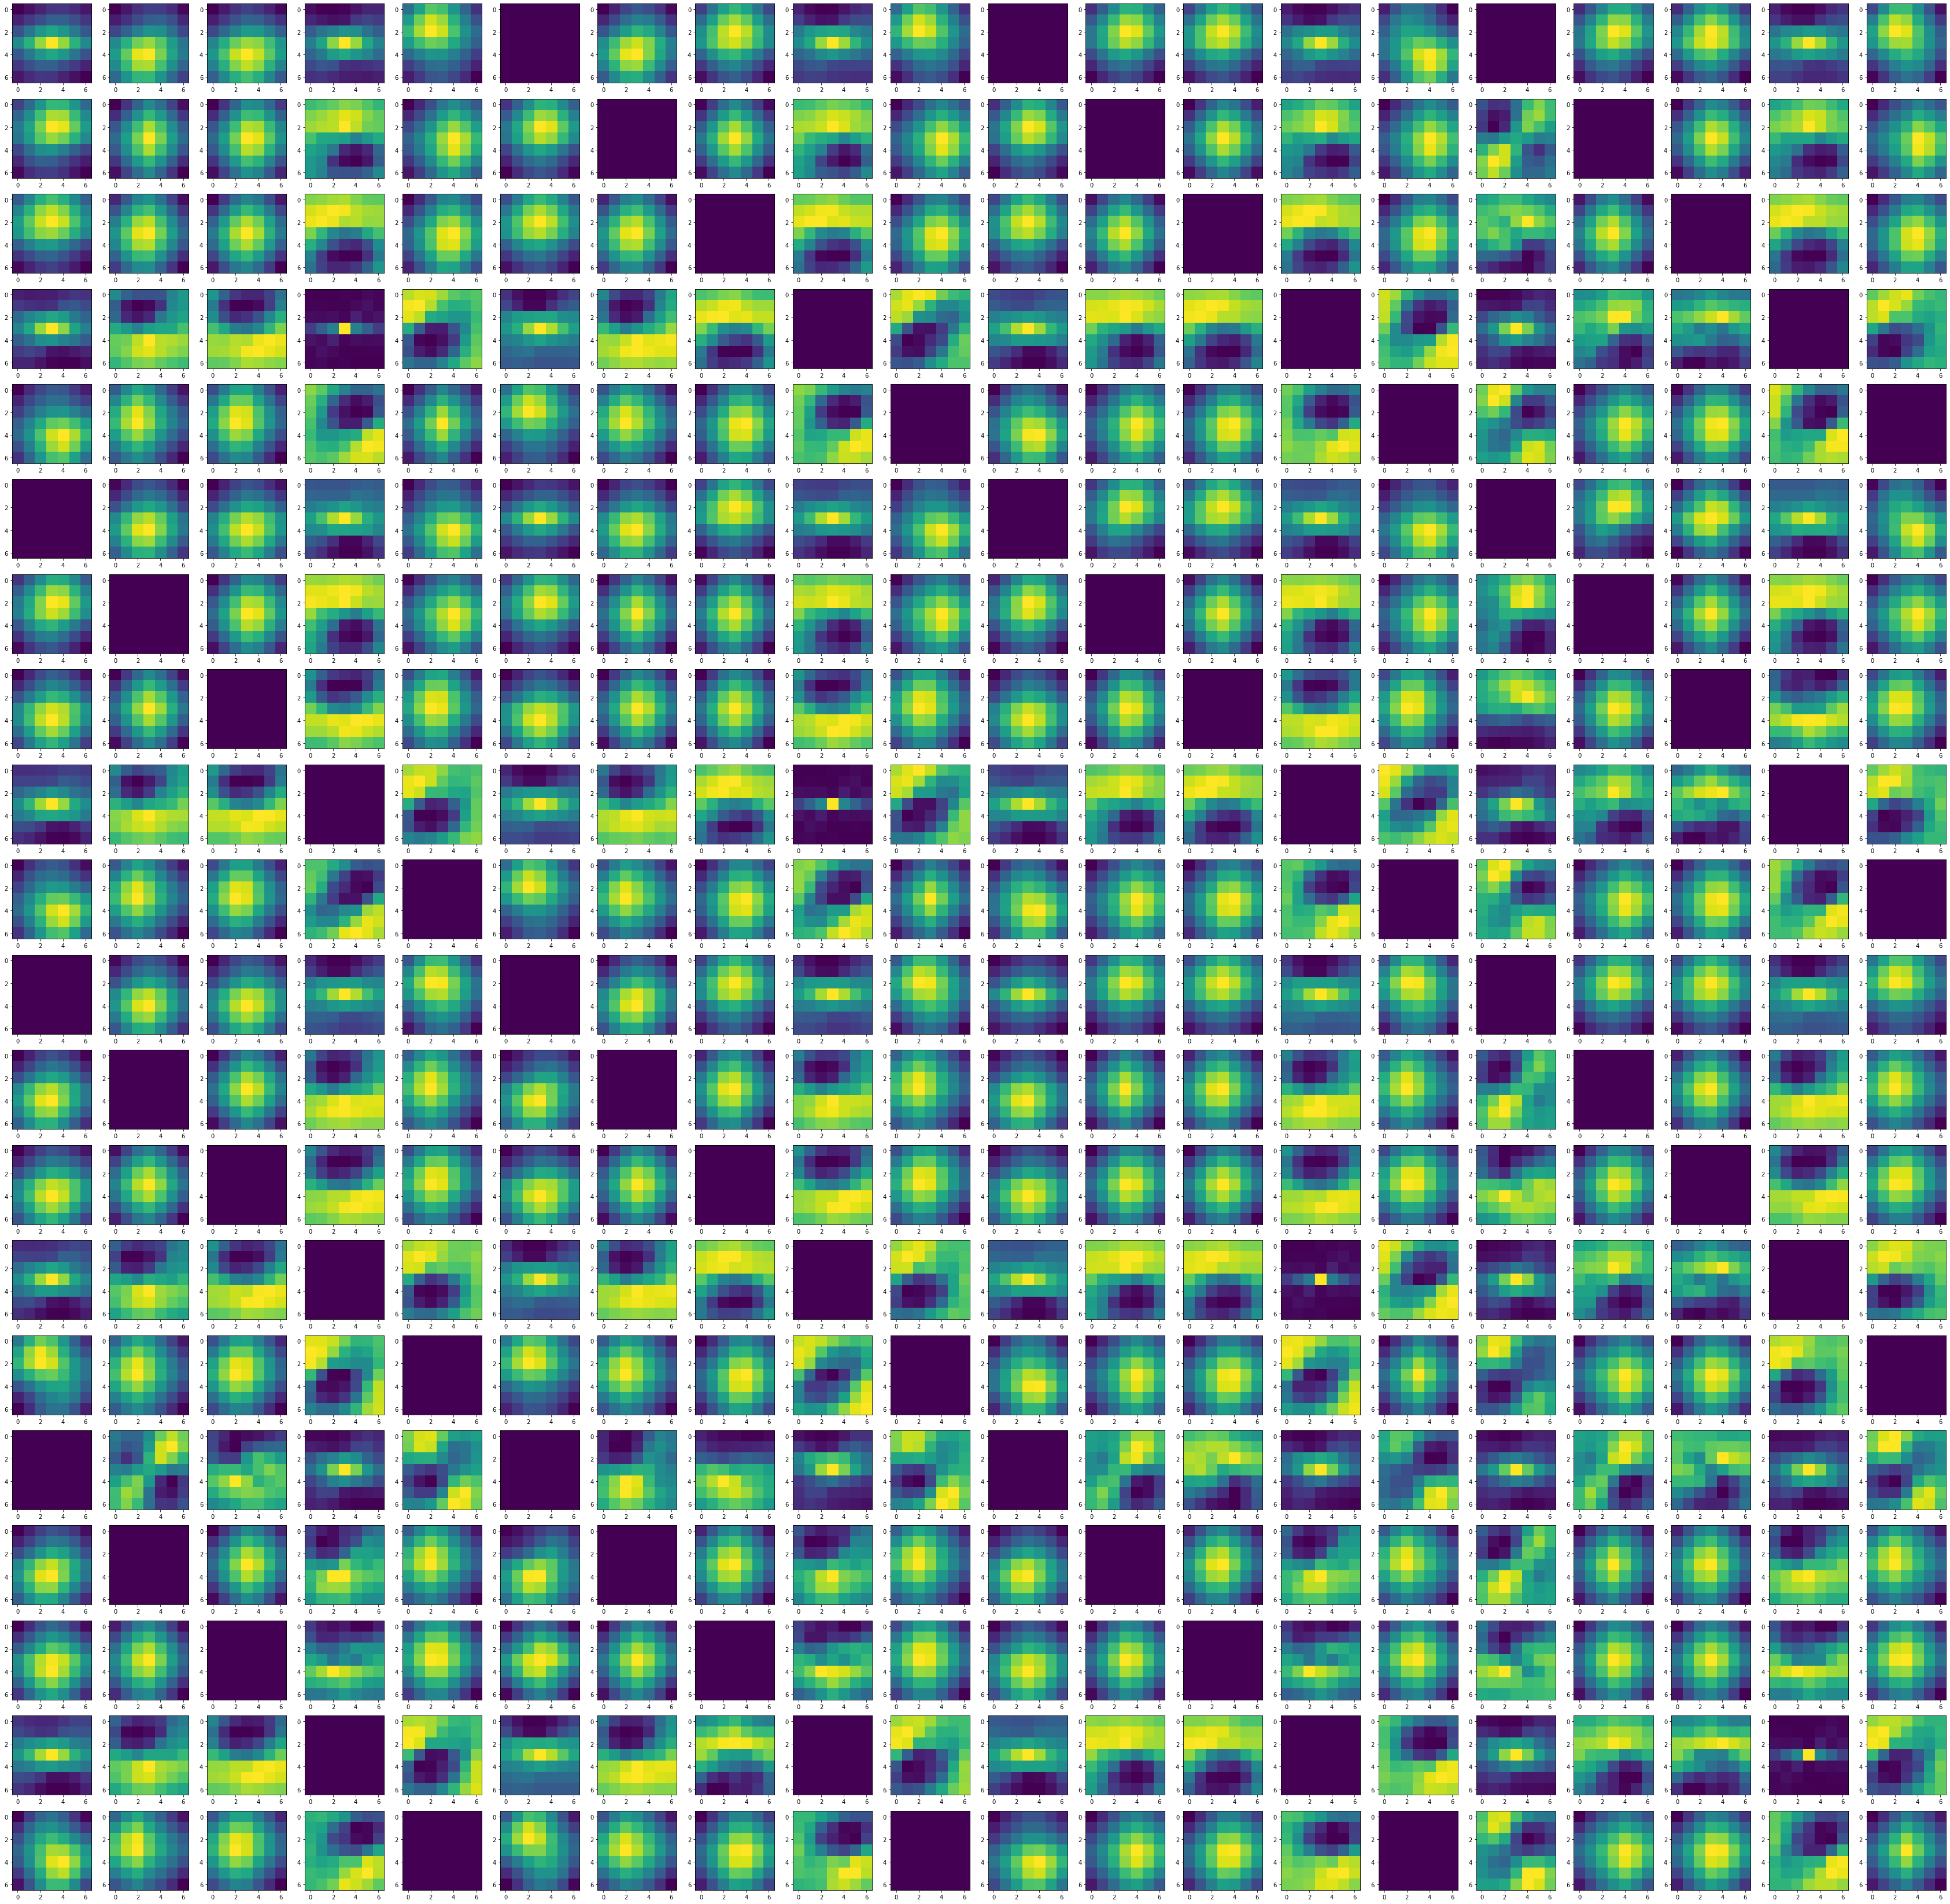

In [102]:
plot_kernels(model)

### Check, if the kernels are symmetrical (identical)

Findings: Kernels are shaped similarly, but their values are different - even if minmax normalized

In [50]:
kernel_data = np.copy(model.lcl.K.cpu().numpy())
for x in range(kernel_data.shape[0]):
    for y in range(kernel_data.shape[1]):
        if x != y:
            print(f"{x}/{y}:\t{np.allclose(kernel_data[x,y], kernel_data[y,x])}\t{np.sum(np.abs(np.subtract(kernel_data[x,y], kernel_data[y,x])))}")

0/1:	False	1.8375072479248047
0/2:	False	1.4033265113830566
0/3:	False	1.302229881286621
0/4:	False	0.9974708557128906
0/5:	True	0.0
0/6:	False	2.6550936698913574
0/7:	False	4.422419548034668
0/8:	False	0.9266262054443359
0/9:	False	2.2562947273254395
0/10:	True	0.0
0/11:	False	4.49089241027832
0/12:	False	4.246603012084961
0/13:	False	1.3152754306793213
0/14:	False	1.236534833908081
0/15:	True	0.0
0/16:	False	4.831437110900879
0/17:	False	3.515829563140869
0/18:	False	1.1411936283111572
0/19:	False	0.5303711891174316
1/0:	False	1.8375072479248047
1/2:	False	2.170546531677246
1/3:	False	0.34721803665161133
1/4:	False	2.0773959159851074
1/5:	False	1.0396333932876587
1/6:	True	0.0
1/7:	False	1.595451831817627
1/8:	False	0.59134840965271
1/9:	False	1.0937259197235107
1/10:	False	0.7514594793319702
1/11:	True	0.0
1/12:	False	1.3128387928009033
1/13:	False	1.1424788236618042
1/14:	False	1.0735588073730469
1/15:	False	1.3226875066757202
1/16:	True	0.0
1/17:	False	7.028883934020996
1/18:	Fals

In [51]:
from lateral_connections.torch_utils import *
kernel_norm = minmax_on_fm(torch.Tensor(kernel_data))
kernel_norm = kernel_norm.numpy()

for x in range(kernel_norm.shape[0]):
    for y in range(kernel_norm.shape[1]):
        if x != y:
            print(f"{x}/{y}:\t{np.allclose(kernel_norm[x,y], kernel_norm[y,x])}\t{np.sum(np.abs(np.subtract(kernel_norm[x,y], kernel_norm[y,x])))}")

0/1:	False	1.8085745573043823
0/2:	False	0.20160135626792908
0/3:	False	0.8626760840415955
0/4:	False	0.2260984480381012
0/5:	True	0.0
0/6:	False	2.417332887649536
0/7:	False	0.6323285102844238
0/8:	False	0.6173696517944336
0/9:	False	0.5281539559364319
0/10:	True	0.0
0/11:	False	3.7526466846466064
0/12:	False	0.5770225524902344
0/13:	False	0.8231116533279419
0/14:	False	0.2856632173061371
0/15:	True	0.0
0/16:	False	4.224581718444824
0/17:	False	0.4976986050605774
0/18:	False	0.7354747653007507
0/19:	False	0.14815890789031982
1/0:	False	1.8085745573043823
1/2:	False	1.5636119842529297
1/3:	False	0.2212027907371521
1/4:	False	2.8427278995513916
1/5:	False	1.0448073148727417
1/6:	True	0.0
1/7:	False	1.1840872764587402
1/8:	False	0.39941543340682983
1/9:	False	1.4716421365737915
1/10:	False	0.6775838136672974
1/11:	True	0.0
1/12:	False	0.9079087972640991
1/13:	False	0.6878420114517212
1/14:	False	1.4351152181625366
1/15:	False	1.3088669776916504
1/16:	True	0.0
1/17:	False	4.72307348251342

array([[0.7700773 , 0.95153046, 1.3418474 , 1.6491628 , 1.4889851 ,
        1.1637677 , 0.93289286],
       [0.80674624, 1.091364  , 1.5953643 , 1.754265  , 1.377147  ,
        1.0717903 , 0.8764215 ],
       [0.7932825 , 1.0703958 , 1.3052684 , 1.0343467 , 1.0023217 ,
        0.98515165, 0.8100577 ],
       [0.78697824, 0.96275645, 0.9872427 , 0.7382675 , 0.9531716 ,
        0.90988135, 0.7479005 ],
       [0.87327474, 1.0502241 , 1.0291673 , 1.0122079 , 1.2525163 ,
        1.0356705 , 0.79040754],
       [0.96016705, 1.1367214 , 1.3891507 , 1.7144067 , 1.5634801 ,
        1.103392  , 0.8383145 ],
       [1.0180513 , 1.2039276 , 1.4795035 , 1.6186416 , 1.3390985 ,
        0.9911561 , 0.81146604]], dtype=float32)

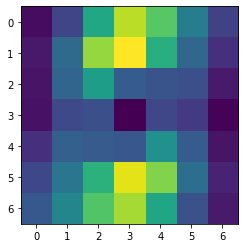

In [55]:
plt.imshow(kernel_data[0,1,...])
kernel_data[0,1,...]

array([[0.81146604, 0.9911561 , 1.3390985 , 1.6186416 , 1.4795035 ,
        1.2039276 , 1.0180513 ],
       [0.8383145 , 1.103392  , 1.5634801 , 1.7144067 , 1.3891507 ,
        1.1367214 , 0.96016705],
       [0.79040754, 1.0356705 , 1.2525163 , 1.0122079 , 1.0291673 ,
        1.0502241 , 0.87327474],
       [0.7479005 , 0.90988135, 0.9531716 , 0.7382675 , 0.9872427 ,
        0.96275645, 0.78697824],
       [0.8100577 , 0.98515165, 1.0023217 , 1.0343467 , 1.3052684 ,
        1.0703958 , 0.7932825 ],
       [0.8764215 , 1.0717903 , 1.377147  , 1.754265  , 1.5953643 ,
        1.091364  , 0.80674624],
       [0.93289286, 1.1637677 , 1.4889851 , 1.6491628 , 1.3418474 ,
        0.95153046, 0.7700773 ]], dtype=float32)

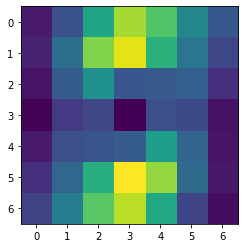

In [54]:
plt.imshow(kernel_data[1,0,...])
kernel_data[1,0,...]

array([[0.03130895, 0.20990504, 0.5940763 , 0.89655274, 0.73889714,
        0.4188005 , 0.1915609 ],
       [0.06740053, 0.34753686, 0.8436014 , 1.        , 0.62882   ,
        0.32827136, 0.13597873],
       [0.05414879, 0.3268988 , 0.5580732 , 0.2914173 , 0.25989658,
        0.24299684, 0.07065985],
       [0.04794379, 0.22095428, 0.24505498, 0.        , 0.21152036,
        0.16891173, 0.00948133],
       [0.1328815 , 0.30704466, 0.28631943, 0.26962706, 0.5061517 ,
        0.29272026, 0.05131909],
       [0.21840565, 0.39218003, 0.6406348 , 0.9607694 , 0.81221926,
        0.35937545, 0.0984717 ],
       [0.27537844, 0.4583281 , 0.7295649 , 0.8665122 , 0.5913706 ,
        0.24890676, 0.072046  ]], dtype=float32)

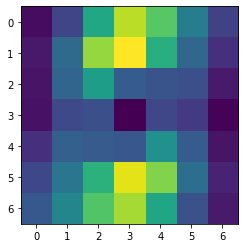

In [53]:
plt.imshow(kernel_norm[0,1,...])
kernel_norm[0,1,...]

array([[0.072046  , 0.24890676, 0.5913706 , 0.8665122 , 0.7295649 ,
        0.4583281 , 0.27537844],
       [0.0984717 , 0.35937545, 0.81221926, 0.9607694 , 0.6406348 ,
        0.39218003, 0.21840565],
       [0.05131909, 0.29272026, 0.5061517 , 0.26962706, 0.28631943,
        0.30704466, 0.1328815 ],
       [0.00948133, 0.16891173, 0.21152036, 0.        , 0.24505498,
        0.22095428, 0.04794379],
       [0.07065985, 0.24299684, 0.25989658, 0.2914173 , 0.5580732 ,
        0.3268988 , 0.05414879],
       [0.13597873, 0.32827136, 0.62882   , 1.        , 0.8436014 ,
        0.34753686, 0.06740053],
       [0.1915609 , 0.4188005 , 0.73889714, 0.89655274, 0.5940763 ,
        0.20990504, 0.03130895]], dtype=float32)

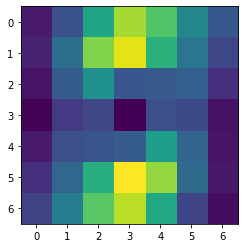

In [52]:
plt.imshow(kernel_norm[1,0,...])
kernel_norm[1,0,...]

## Softmax vs. LogSoftmax

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


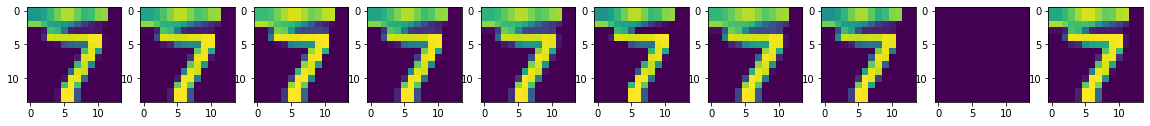

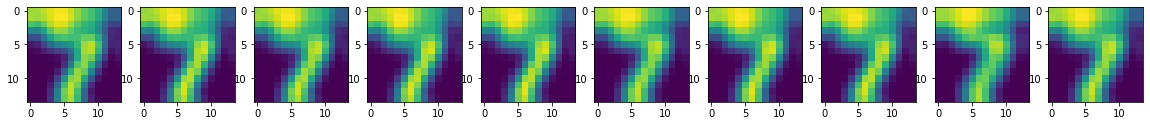

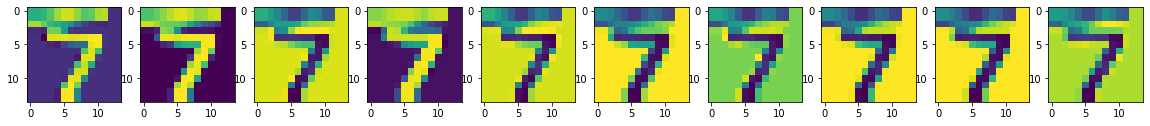

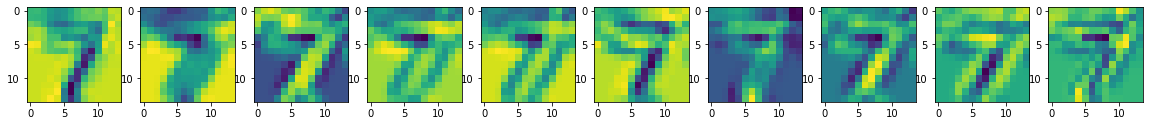

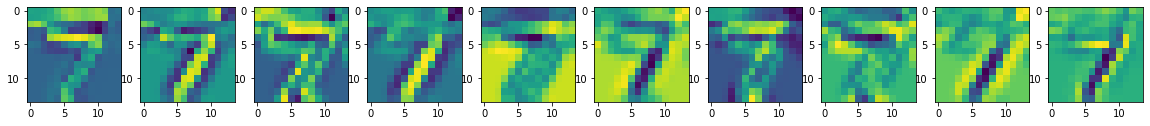

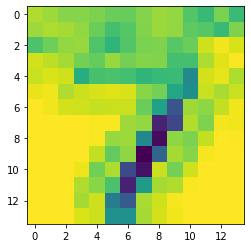

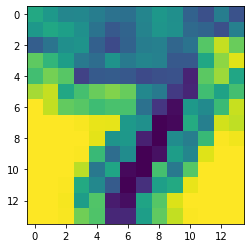

In [51]:

def plot_along_axis(data, N=10, plot_scale=2):
    fig, axs = plt.subplots(1, N, figsize=(plot_scale*N, plot_scale))
    for ax_id in range(N):
        axs[ax_id].imshow(data[0,ax_id, :, :].cpu().detach().numpy())
    plt.show()
        

img_batch, labels = next(iter(corrupt_loader))
print(labels)
img_batch = img_batch.to(model.device)
conv = model.conv1(img_batch)
conv = model.relu1(conv)
conv = model.conv2(conv)
conv = model.relu2(conv)
conv = model.maxpool(conv)

conv = symmetric_padding(conv, 1)

lcl_o = model.lcl(conv)

# Inside LCL
A = conv.repeat(1, model.lcl.n, 1, 1)
padA = model.lcl.pad_activations(A)
padA = symmetric_padding(padA, 3)
L = F.conv2d(padA, minmax_on_fm(model.lcl.K.transpose_(0,1)), padding=0) / model.lcl.num_fm

plot_along_axis(A)
plot_along_axis(L)
plot_along_axis(torch.nn.functional.log_softmax(A, dim=1))
plot_along_axis(torch.nn.functional.log_softmax(L, dim=1))
plot_along_axis(torch.nn.functional.log_softmax(0.5*A+0.5*L, dim=1))

summed_A_L = torch.sum(torch.nn.functional.log_softmax(0.5*A+0.5*L, dim=1), axis=1)[0].cpu().detach().numpy()
plt.imshow(summed_A_L)
plt.show()

#log_sum_exp_A_L = torch.exp(torch.sum(torch.log(0.5*A+0.5*L), dim=1))[0].cpu().detach().numpy()


x = torch.nn.functional.log_softmax(0.5*A+0.5*L, dim=1)
log_sum_exp_A_L = torch.exp(torch.sum(x, axis=1))[0].cpu().detach().numpy()

plt.imshow(log_sum_exp_A_L)
plt.show()

#summed_A_L

#plot_along_axis(softmax_minmax_scaled(0.5*A+0.5*L))


# TODO: Check Plot A and L with Softmax vs. LogSoftmax vs. MinMax'd versions

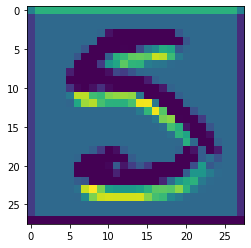

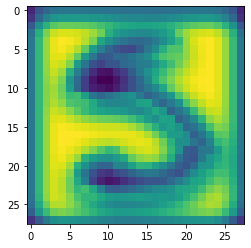

/tmp/ipykernel_705/2569348075.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  lcl_lsm = torch.nn.functional.log_softmax(lcl_o[0,0]).cpu().detach().numpy()


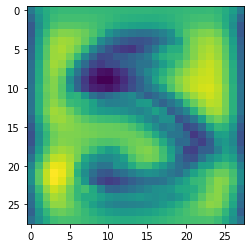

/tmp/ipykernel_705/2569348075.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  lcl_lsm_mms = minmax_on_fm(torch.nn.functional.log_softmax(lcl_o[0,0]).unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0,0]


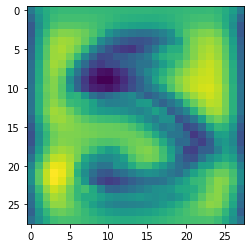

/tmp/ipykernel_705/2569348075.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  lcl_sm = torch.nn.functional.softmax(lcl_o[0,0]).cpu().detach().numpy()


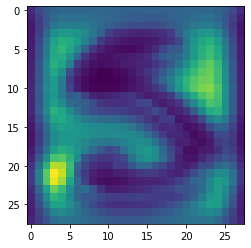

/tmp/ipykernel_705/2569348075.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  lcl_sm_mms = minmax_on_fm(torch.nn.functional.softmax(lcl_o[0,0]).unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0,0]


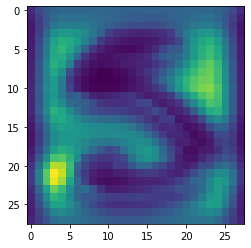

[-4.0424957 -3.60423   -3.4029098 -3.2696798 -3.24039   -3.24039
 -3.24039   -3.240437  -3.2414207 -3.246696  -3.2570472 -3.2675948
 -3.276176  -3.2807498 -3.2824907 -3.2876732 -3.2942648 -3.292869
 -3.283002  -3.2674856 -3.2520106 -3.24327   -3.240982  -3.2404504
 -3.2832365 -3.3991897 -3.584909  -4.01839  ]

[0.01755361 0.02720838 0.0332763  0.0380186  0.03914862 0.03914862
 0.03914862 0.03914677 0.03910828 0.03890252 0.03850192 0.03809794
 0.03777242 0.03760004 0.03753464 0.03734063 0.03709531 0.03714711
 0.03751546 0.03810211 0.03869633 0.03903604 0.03912545 0.03914626
 0.03750667 0.03340032 0.02773919 0.01798189]


In [11]:
plt.imshow(conv.cpu().detach().numpy()[0,0])
plt.show()

plt.imshow(lcl_o.cpu().detach().numpy()[0,0])
plt.show()

lcl_lsm = torch.nn.functional.log_softmax(lcl_o[0,0]).cpu().detach().numpy()
plt.imshow(lcl_lsm)
plt.show()

lcl_lsm_mms = minmax_on_fm(torch.nn.functional.log_softmax(lcl_o[0,0]).unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0,0]
plt.imshow(lcl_lsm_mms, vmin=0, vmax=1)
plt.show()
lcl_lsm_mms

lcl_sm = torch.nn.functional.softmax(lcl_o[0,0]).cpu().detach().numpy()
plt.imshow(lcl_sm)
plt.show()

lcl_sm_mms = minmax_on_fm(torch.nn.functional.softmax(lcl_o[0,0]).unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0,0]
plt.imshow(lcl_sm_mms, vmin=0, vmax=1)
plt.show()


print(lcl_lsm[0])
print('')
print(lcl_sm[0])

### Manual LCL Calculation (debug)

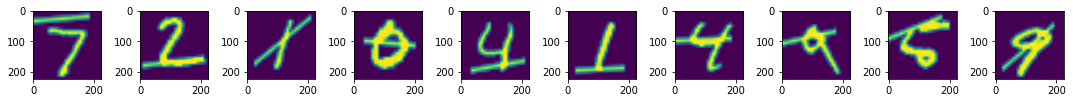

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [14]:
# Load a batch of images
#img_batch, labels = next(iter(train_loader))
img_batch, labels = next(iter(corrupt_loader))

# Plot the images
fig, axs = plt.subplots(1, 10, figsize=(15,4))
for i in range(img_batch.shape[0]):
    axs[i].imshow(img_batch[i,0,...])
plt.tight_layout()
plt.show()
plt.close()

labels

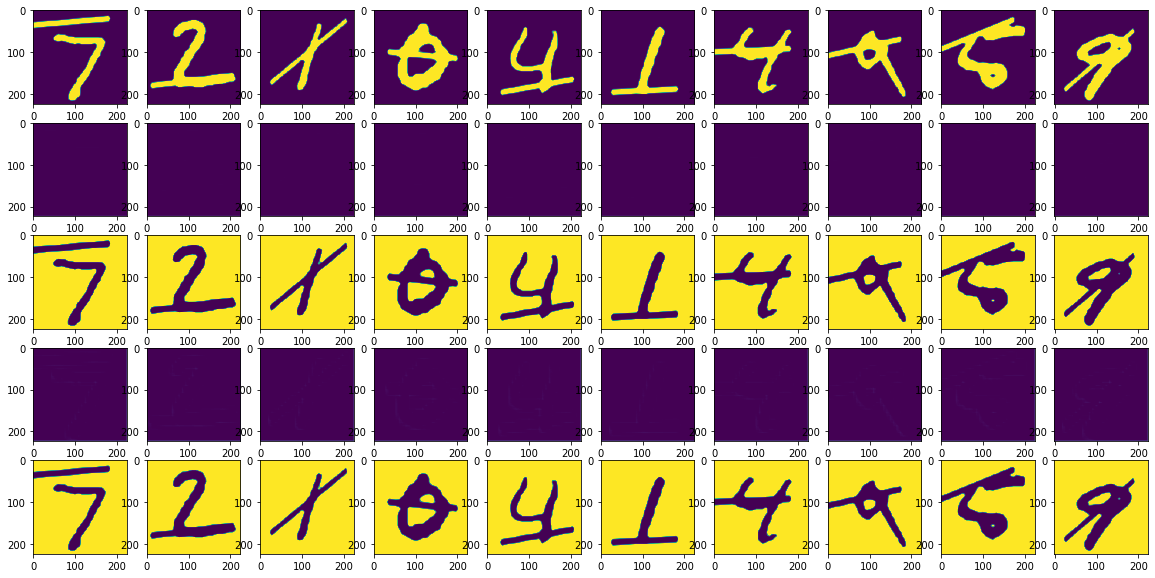

In [15]:
"""
x = self.conv1(x)
x = self.relu1(x)
x = self.lcl(x)
x = torch.flatten(x, 1)

x = self.fc1(x)
x = self.relu2(x)
x = self.fc2(x)
"""

img_batch = img_batch.to(model.device)
conv = model.conv1(img_batch)
conv = model.relu1(conv)

fig, axs = plt.subplots(5, 10, figsize=(20,10))

for x in range(5):
    for y in range(10):
        axs[x,y].imshow(conv[y, x, ...].cpu().detach().numpy(), vmin=0, vmax=1)

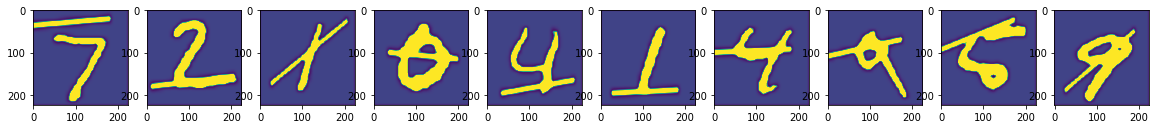

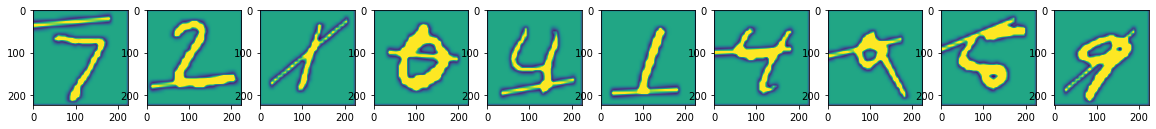

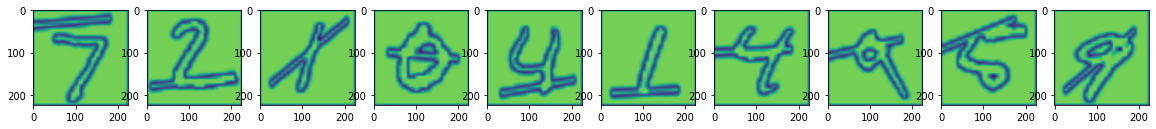

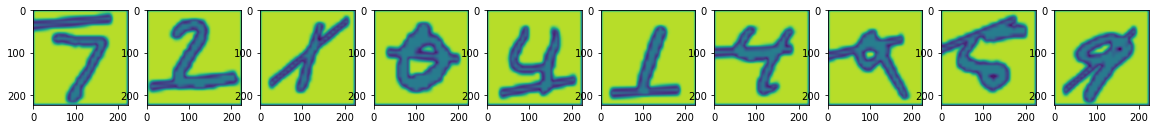

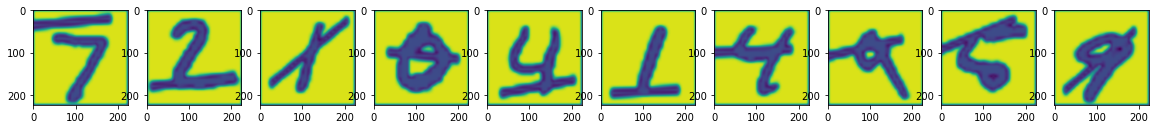

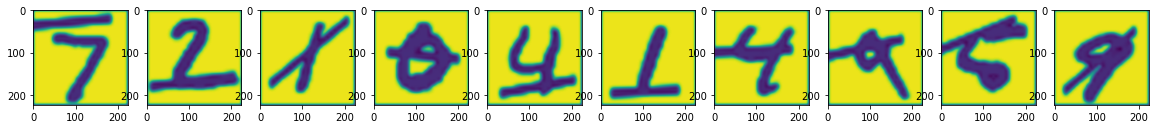

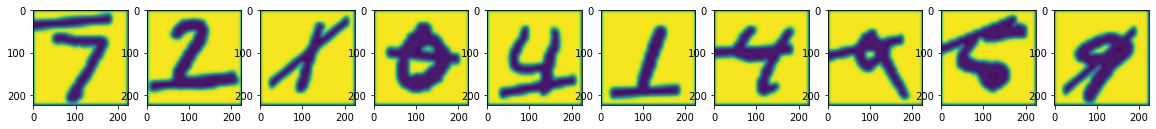

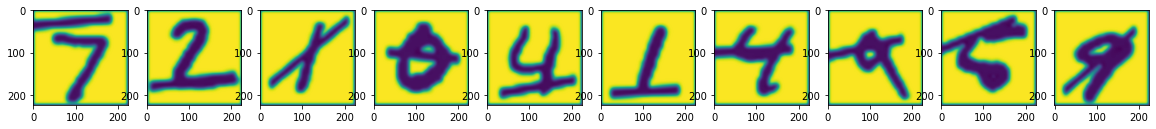

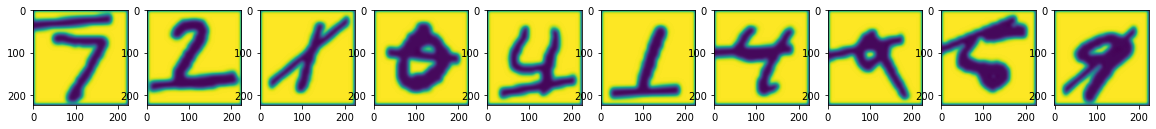

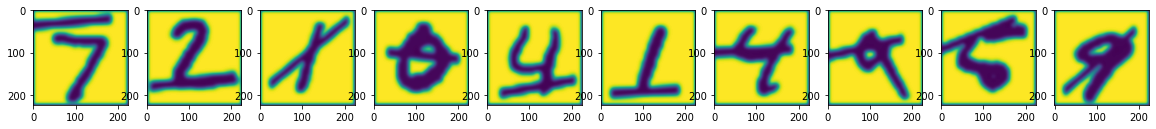

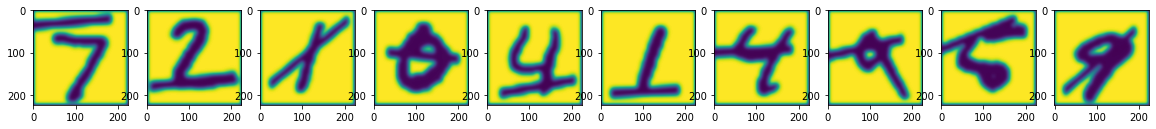

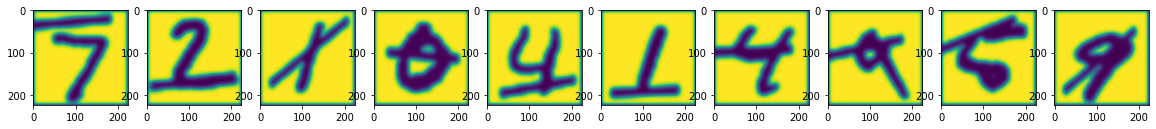

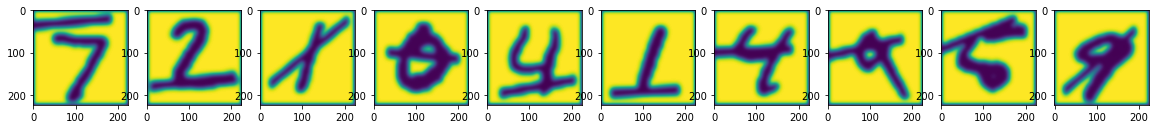

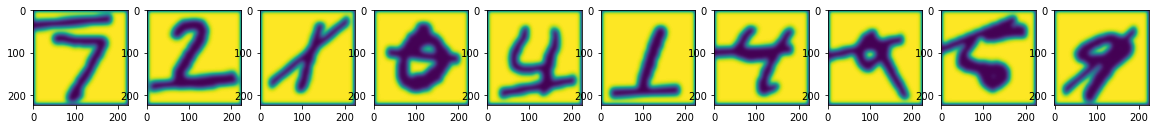

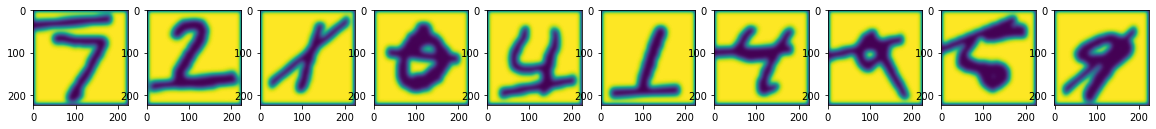

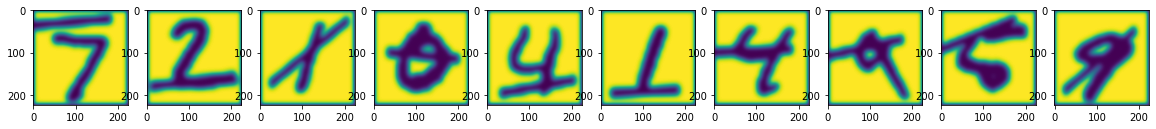

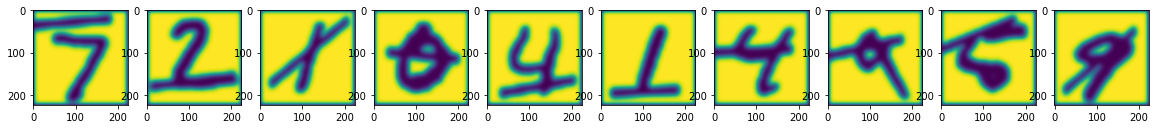

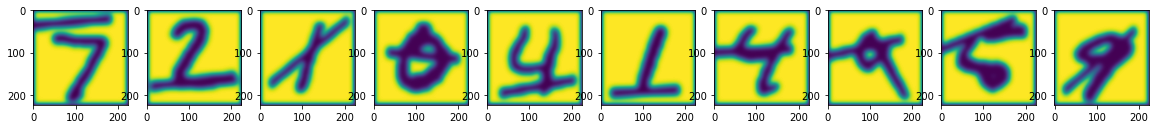

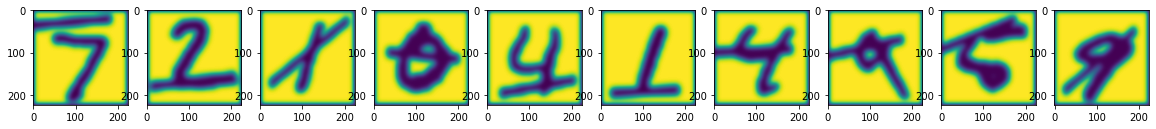

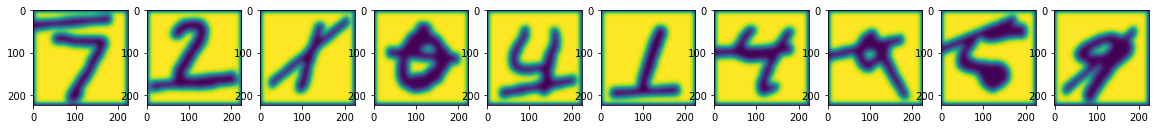

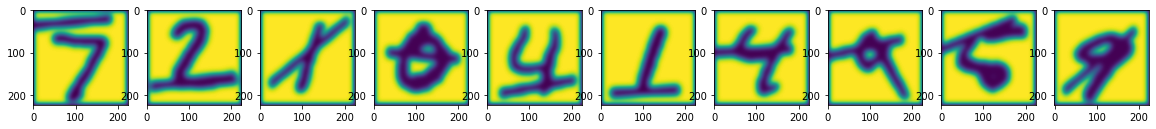

KeyboardInterrupt: 

In [16]:
# Do manual LCL

lcl_input = conv

A = lcl_input.repeat(1, model.lcl.n, 1, 1)

for k in range(100):
    L = F.conv2d(A, model.lcl.K.transpose_(0, 1), padding=3)
    #L = F.conv2d(L, minmax_on_fm(model.lcl.K.transpose_(0, 1)), padding=3)
    L = minmax_on_fm(L)
    A = 0.8 * A + 0.2 * L

    if k % 3 == 0:
        fig, axs = plt.subplots(1, 10, figsize=(20,5))
        for y in range(10):
            axs[y].imshow(A.cpu().detach().numpy()[y, 0, ...], vmin=0, vmax=1)
        plt.show()
        plt.close()

"""
#L = softmax_minmax_scaled(L)
L = minmax_on_fm(L)

fig, axs = plt.subplots(5, 10, figsize=(20,10))
for x in range(5):
    for y in range(10):
        axs[x,y].imshow(L.cpu().detach().numpy()[y, x, ...], vmin=0, vmax=1)
plt.show()
plt.close()
"""

## Adversarial Example

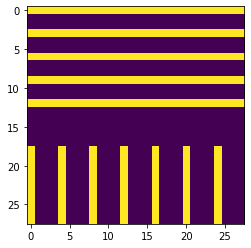

In [8]:
imgs, lbls = next(iter(train_loader))

imgs.shape, lbls.shape

labels = torch.arange(10)

images = torch.zeros((10, 1, 28, 28))
images[:, 0,0:14:3,:] = 1
images[:, 0,-10:,0::4] = 1

plt.imshow(images[0,0])

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


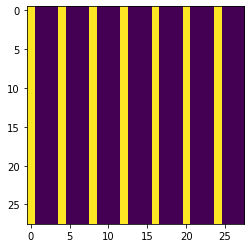

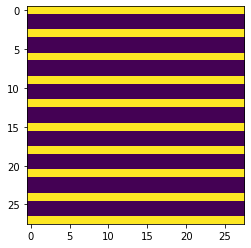

In [9]:
images = torch.zeros((10, 1, 28, 28))
images[:5, 0, :, 0::4] = 1.
images[5:, 0, 0::3, :] = 1.

labels = torch.LongTensor([0,0,0,0,0,1,1,1,1,1])
print(labels)

plt.imshow(images[0, 0])
plt.show()
plt.imshow(images[9, 0])

In [10]:
images_A = images[:5].repeat(2, 1, 1, 1)
images_B = images[5:].repeat(2, 1, 1, 1)

labels_A = labels[:5].repeat(2)
labels_B = labels[5:].repeat(2)

labels_A, labels_B

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

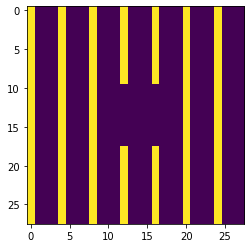

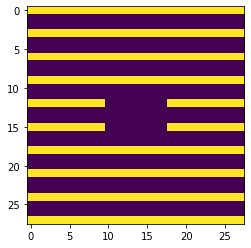

In [69]:
images_test = torch.clone(images)

images_test[:,:,10:18, 10:18] = 0
plt.imshow(images_test[0,0].cpu())
plt.show()
plt.imshow(images_test[9,0].cpu())

In [12]:
model = TinyLateralNetwork(config)
model.to(model.device)

images = images.to(model.device)
labels = labels.to(model.device)
images_A = images_A.to(model.device)
images_B = images_B.to(model.device)
labels_A = labels_A.to(model.device)
labels_B = labels_B.to(model.device)
images_test = images_test.to(model.device)

k_hist = np.zeros((2, 2500//2, config['conv_size']))
k_hist.shape

(2, 1250, 8)

In [13]:
#model.lcl.eta = nn.Parameter(torch.zeros(1).to(model.device))
model.lcl.eta

Parameter containing:
tensor([0.0500], device='cuda:0')

In [14]:
for i in tqdm(range(250)):
    if i % 2 == 0:
        batch = images_A.to(model.device)
        batch_labels = labels_A.to(model.device)
    else:
        batch = images_B.to(model.device)
        batch_labels = labels_B.to(model.device)
        
    outputs = model(batch)
    loss = model.loss_fn(outputs, batch_labels)
    
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    
    if i%2 == 0:
        k_hist[0,i//2,:] = model.lcl.current_k_indices[0,:,0].cpu().detach().numpy()
    else:
        k_hist[1,i//2,:] = model.lcl.current_k_indices[0,:,0].cpu().detach().numpy()
        

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([10, 8, 14, 14])


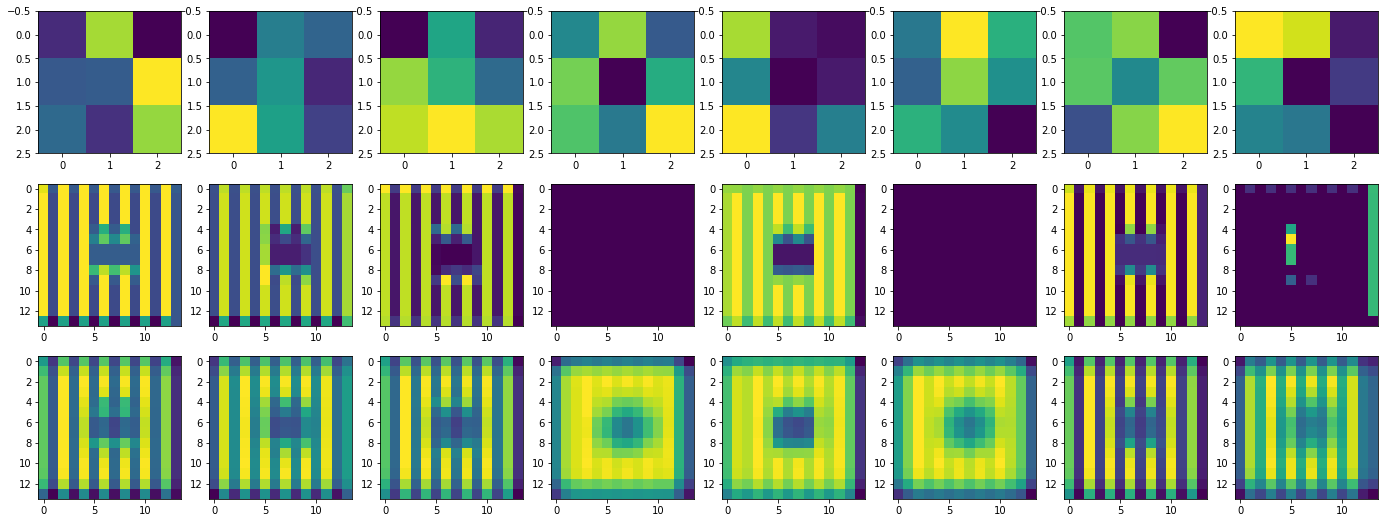

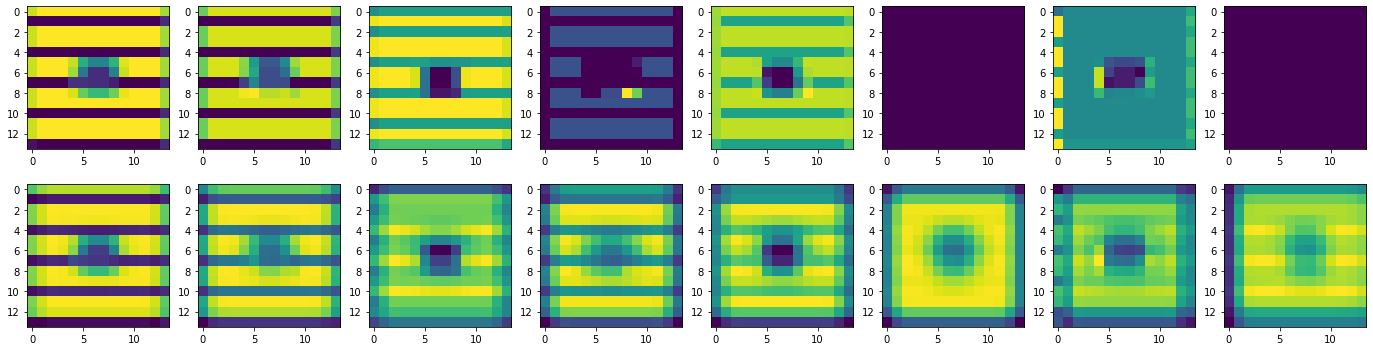

In [72]:
s1, _, _, _ = model.conv1.weight.shape
plot_scale = 3

conv = model.conv1(images_test)
conv = model.relu1(conv)
conv = model.conv2(conv)
conv = model.relu2(conv)
conv = model.maxpool(conv)
print(conv.shape)

lcl_o = model.lcl(conv)

fig, axs = plt.subplots(3, s1, figsize=(s1*plot_scale, 3*plot_scale))

for x in range(s1):
    axs[0,x].imshow(model.conv1.weight.cpu().detach().numpy()[x, 0, ...])
    axs[1,x].imshow(conv.cpu().detach().numpy()[0, x, ...])
    axs[2,x].imshow(lcl_o.cpu().detach().numpy()[0, x, ...])

fig, axs = plt.subplots(2, s1, figsize=(s1*plot_scale, 2*plot_scale))

for x in range(s1):
    axs[0,x].imshow(conv.cpu().detach().numpy()[9, x, ...])
    axs[1,x].imshow(lcl_o.cpu().detach().numpy()[9, x, ...])

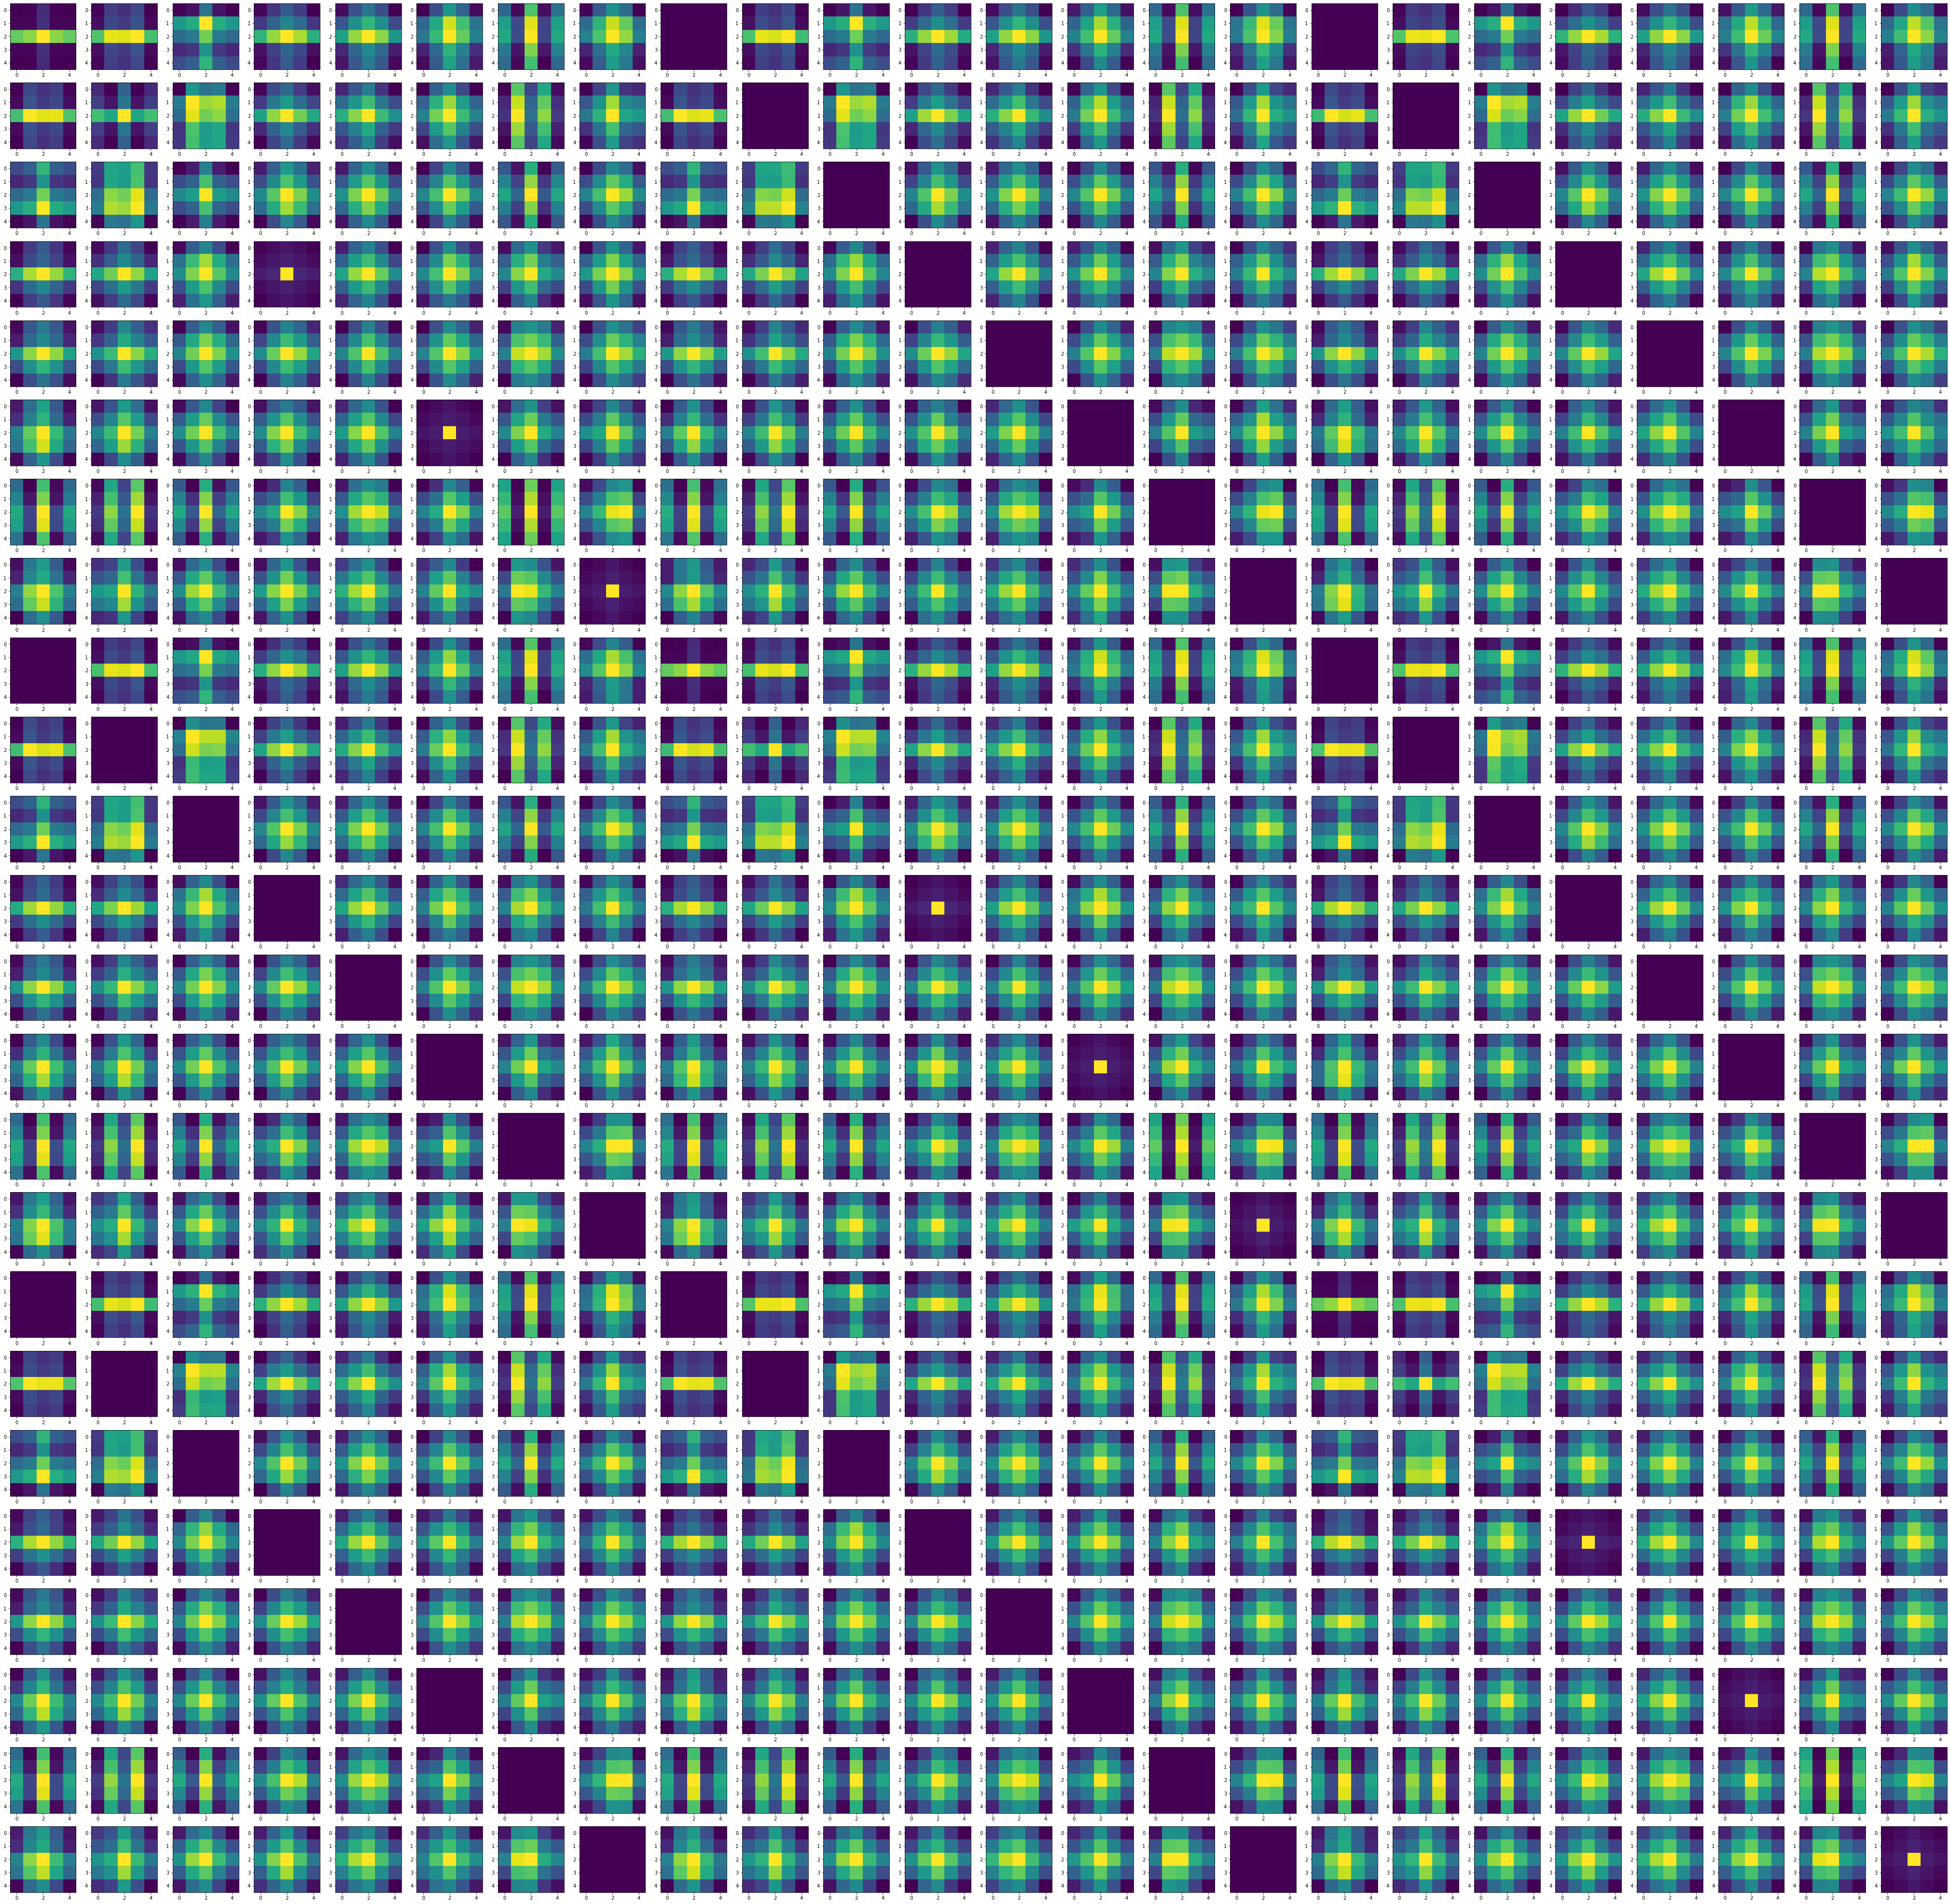

In [16]:
# Mit Noise trainiert
plot_kernels(model)

In [17]:
for i in tqdm(range(2250)):
    if i % 2 == 0:
        batch = images_A.to(model.device)
        batch_labels = labels_A.to(model.device)
    else:
        batch = images_B.to(model.device)
        batch_labels = labels_B.to(model.device)
        
    outputs = model(batch)
    loss = model.loss_fn(outputs, batch_labels)
    
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    
    if i%2 == 0:
        k_hist[0,(250+i)//2,:] = model.lcl.current_k_indices[0,:,0].cpu().detach().numpy()
    else:
        k_hist[1,(250+i)//2,:] = model.lcl.current_k_indices[0,:,0].cpu().detach().numpy()
        

  0%|          | 0/2250 [00:00<?, ?it/s]

torch.Size([10, 8, 14, 14])


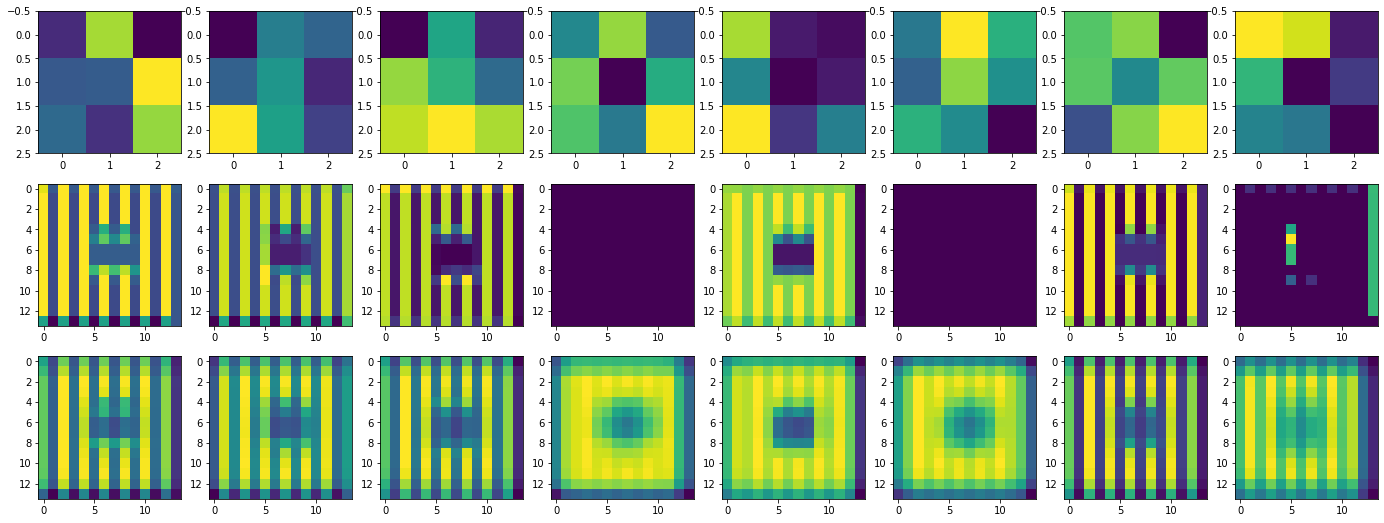

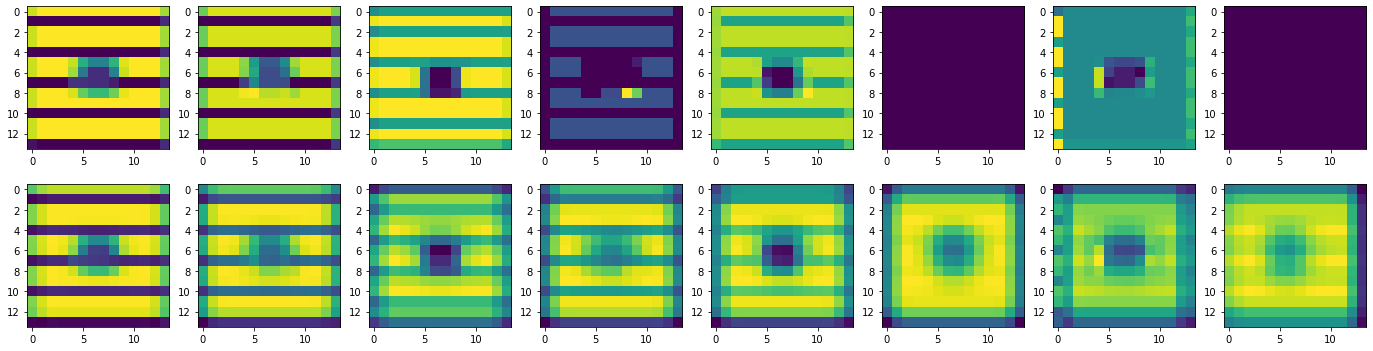

In [73]:
s1, _, _, _ = model.conv1.weight.shape
plot_scale = 3

conv = model.conv1(images_test)
conv = model.relu1(conv)
conv = model.conv2(conv)
conv = model.relu2(conv)
conv = model.maxpool(conv)
print(conv.shape)

lcl_o = model.lcl(conv)

fig, axs = plt.subplots(3, s1, figsize=(s1*plot_scale, 3*plot_scale))

for x in range(s1):
    axs[0,x].imshow(model.conv1.weight.cpu().detach().numpy()[x, 0, ...])
    axs[1,x].imshow(conv.cpu().detach().numpy()[0, x, ...])
    axs[2,x].imshow(lcl_o.cpu().detach().numpy()[0, x, ...])

fig, axs = plt.subplots(2, s1, figsize=(s1*plot_scale, 2*plot_scale))

for x in range(s1):
    axs[0,x].imshow(conv.cpu().detach().numpy()[9, x, ...])
    axs[1,x].imshow(lcl_o.cpu().detach().numpy()[9, x, ...])

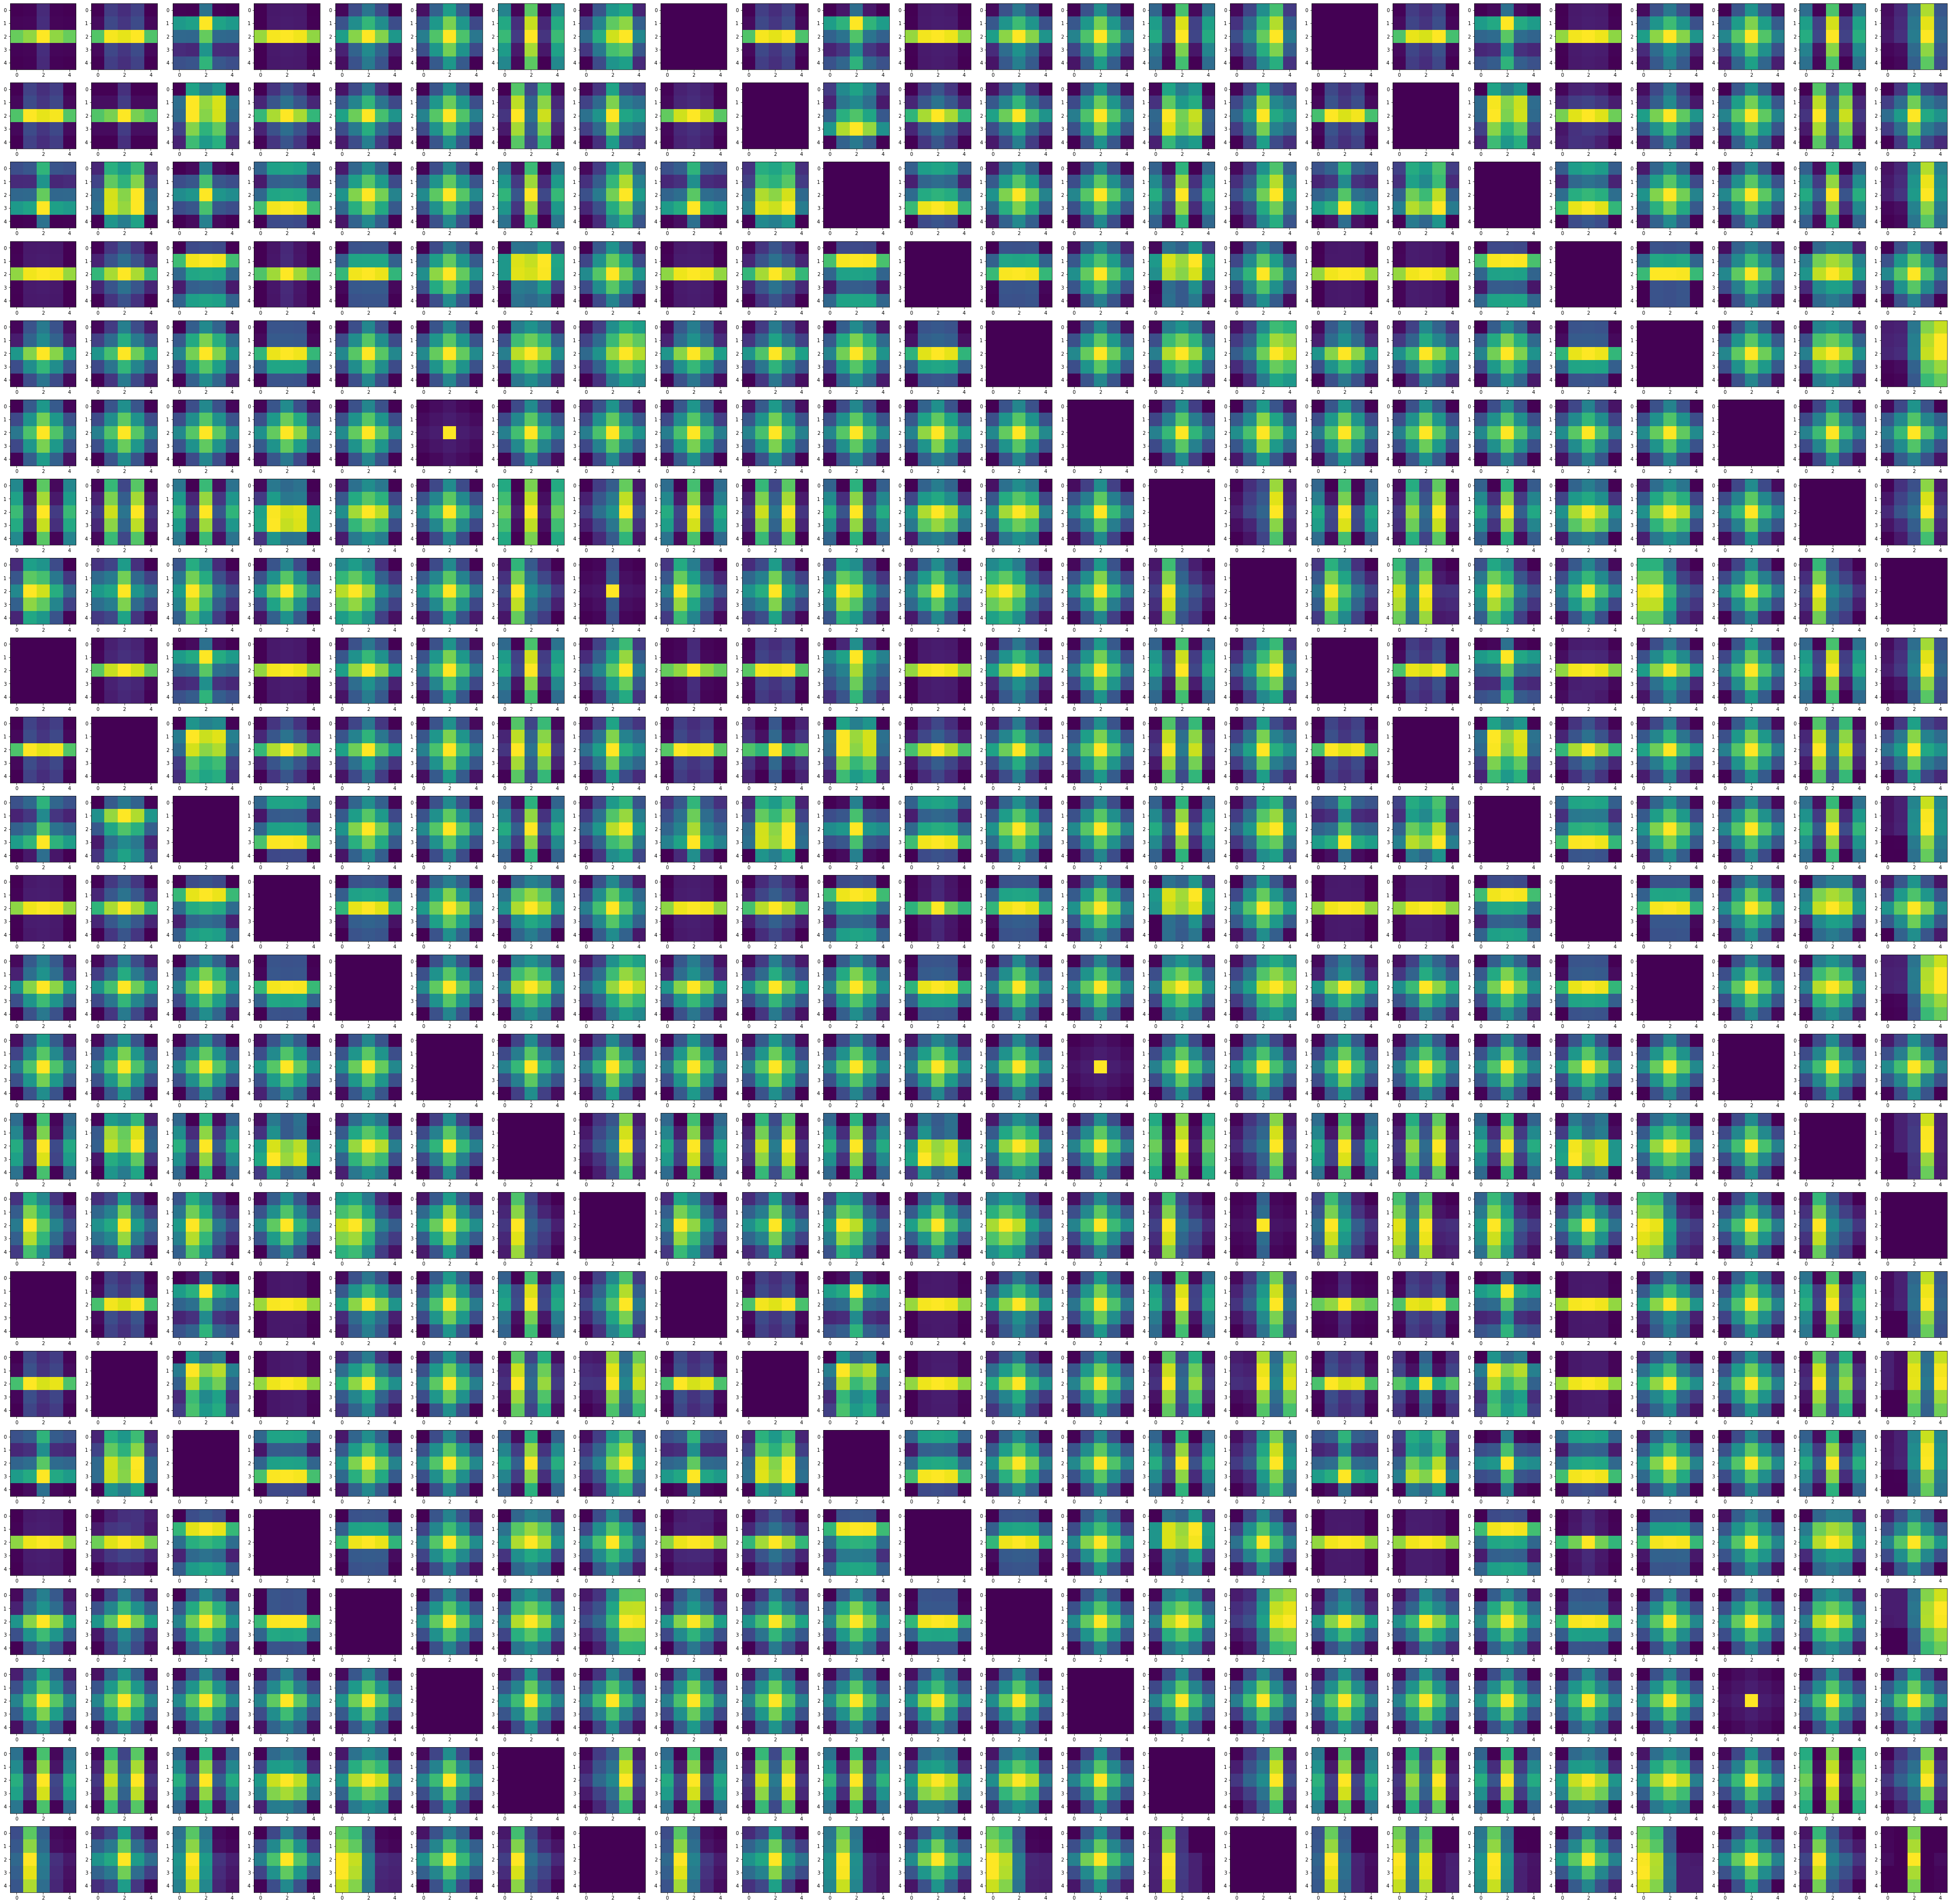

In [19]:
# Erst mit noise trainiert, danach ohne
plot_kernels(model)

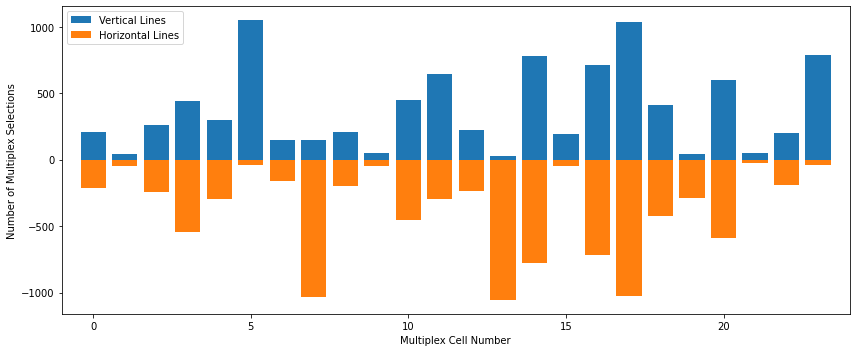

In [56]:
plt.figure(figsize=(12,5))
val, cnt = np.unique(k_hist[0, 125:], return_counts=True)
plt.bar(val, cnt)
val, cnt = np.unique(k_hist[1, 125:], return_counts=True)
plt.bar(val, -cnt)
plt.xlim(-1, 24)
plt.ylabel('Number of Multiplex Selections')
plt.xlabel('Multiplex Cell Number')
plt.tight_layout()
plt.legend(['Vertical Lines', 'Horizontal Lines'], loc='upper left')
plt.show()

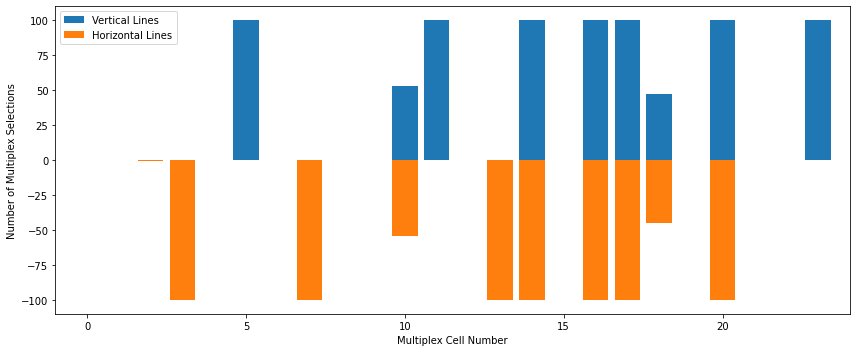

In [55]:
plt.figure(figsize=(12,5))
val, cnt = np.unique(k_hist[0, -100:], return_counts=True)
plt.bar(val, cnt)
val, cnt = np.unique(k_hist[1, -100:], return_counts=True)
plt.bar(val, -cnt)
plt.xlim(-1, 24)
plt.ylabel('Number of Multiplex Selections')
plt.xlabel('Multiplex Cell Number')
plt.tight_layout()
plt.legend(['Vertical Lines', 'Horizontal Lines'], loc='upper left')
plt.show()

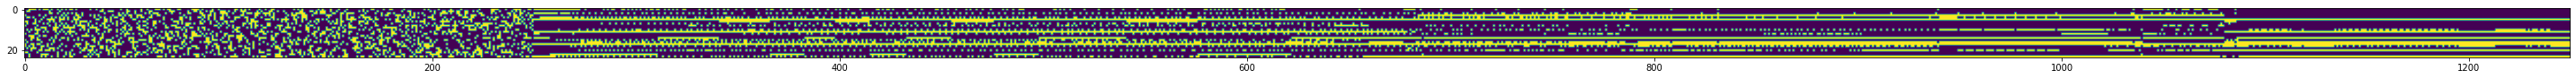

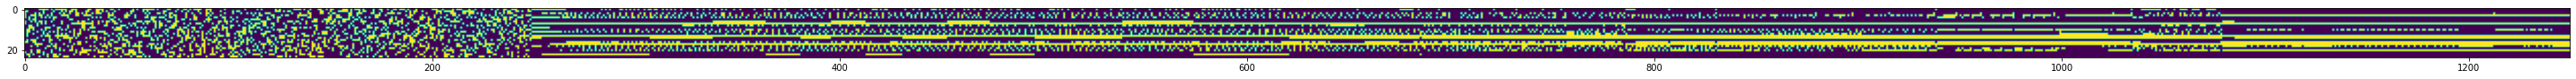

In [68]:
x = np.zeros((1250, 24))
for i, row in enumerate(k_hist[0].astype(int)):
    x[i, np.sort(row)] = 1
    
plt.figure(figsize=(100,1))
plt.imshow(x.transpose())
plt.show()

x = np.zeros((1250, 24))
for i, row in enumerate(k_hist[1].astype(int)):
    x[i, np.sort(row)] = 1
    
plt.figure(figsize=(100,1))
plt.imshow(x.transpose())
plt.show()